# Explore here

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import mean_squared_error, r2_score
from pickle import dump



In [4]:
# Apertura de datasets

#El archivo appearence_agrupado, ha sido trabajado en el google colab en el siguiente link:
#https://colab.research.google.com/drive/1kkoDlp4htYlhvd1pJ4Mg8GcqiJniWnwx#scrollTo=55sTvyXtUQs0
#pues el original tiene un tamaño grande y no permitía trabajarlo en github.
appearence = pd.read_csv("/workspaces/proyecto_final_transfer/data/datos_de_transfer/proyecto final/appearence_agrupado.csv")
players = pd.read_csv("/workspaces/proyecto_final_transfer/data/datos_de_transfer/proyecto final/players.csv")
player_valuations = pd.read_csv("/workspaces/proyecto_final_transfer/data/datos_de_transfer/proyecto final/player_valuations.csv")

ds_players_info= {"Appearence": appearence, "Players":players, "Player Valuations":player_valuations}

for name, dataset in ds_players_info.items():
    print(f"El shape de {name}: {dataset.shape}")


El shape de Appearence: (203718, 12)
El shape de Players: (32480, 23)
El shape de Player Valuations: (494561, 5)


In [5]:
for name, dataset in ds_players_info.items():
    print(f"Las columnas de {name}: {dataset.columns}")

Las columnas de Appearence: Index(['player_id', 'year', 'competition_id', 'club_name', 'player_name',
       'matches_played', 'yellow_cards', 'red_cards', 'goals', 'assists',
       'minutes_played', 'age'],
      dtype='object')
Las columnas de Players: Index(['player_id', 'first_name', 'last_name', 'name', 'last_season',
       'current_club_id', 'player_code', 'country_of_birth', 'city_of_birth',
       'country_of_citizenship', 'date_of_birth', 'sub_position', 'position',
       'foot', 'height_in_cm', 'contract_expiration_date', 'agent_name',
       'image_url', 'url', 'current_club_domestic_competition_id',
       'current_club_name', 'market_value_in_eur',
       'highest_market_value_in_eur'],
      dtype='object')
Las columnas de Player Valuations: Index(['player_id', 'date', 'market_value_in_eur', 'current_club_id',
       'player_club_domestic_competition_id'],
      dtype='object')


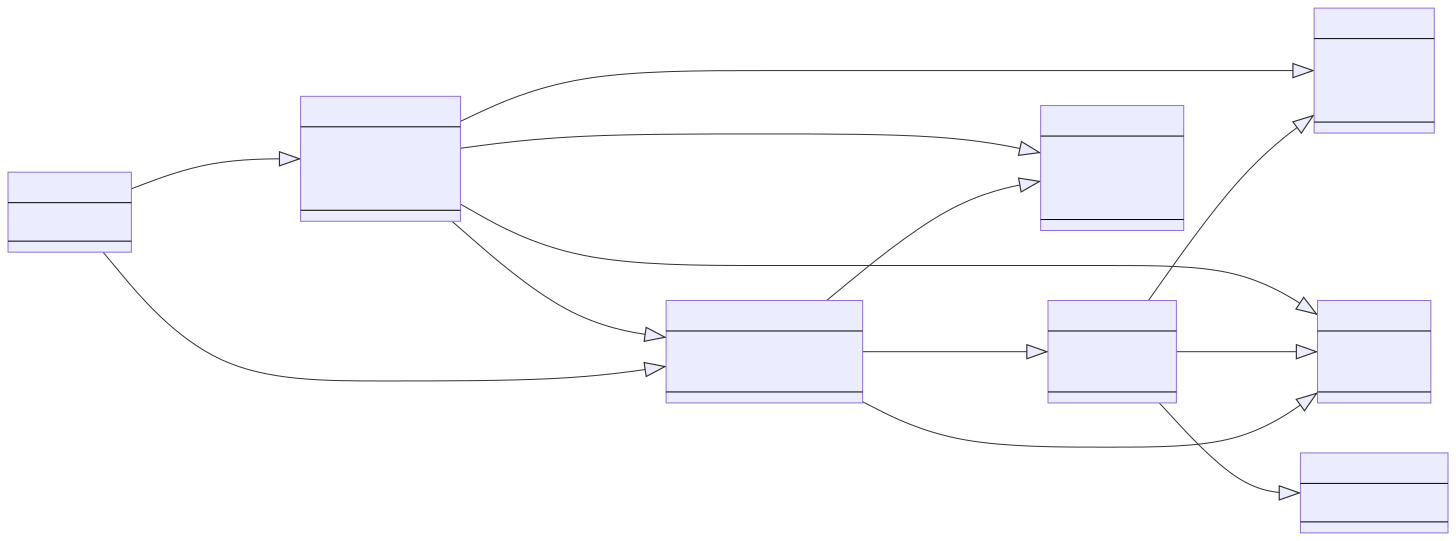

In [12]:
from IPython.display import SVG, display

display(SVG(filename="/workspaces/proyecto_final_transfer/data/datos_de_transfer/proyecto final/diagram.svg"))

### Dataset filtrados por columnas relevantes:

In [61]:
#Edad del jugador con números enteros:
appearence['age'] = appearence['age'].astype(int)

#Filtrado:
player_valuations_filtered=player_valuations.drop(["current_club_id", "player_club_domestic_competition_id"], axis = 1)
players_filtered=players.drop(["first_name", "last_name", "last_season", "current_club_id", "player_code", "contract_expiration_date","agent_name","image_url","url", "current_club_domestic_competition_id","current_club_name","market_value_in_eur"], axis = 1)

Groupby Player_valuation

In [62]:
# 1. Convertir la columna 'date' al formato datetime (si no lo está ya)
player_valuations_filtered['date'] = pd.to_datetime(player_valuations_filtered['date'])

# 2. Crear una nueva columna que contenga el año del partido
player_valuations_filtered['year'] = player_valuations_filtered['date'].dt.year

# 3. Agrupar por 'player_id' y 'year', y calcular agregados para cada columna relevante
gb_player_val = player_valuations_filtered.groupby(['player_id', 'year']).agg({
    "market_value_in_eur":"mean"
}).reset_index()

# 4. Ver el resultado
print(gb_player_val)

        player_id  year  market_value_in_eur
0              10  2004            7000000.0
1              10  2005           12000000.0
2              10  2006           25000000.0
3              10  2007           23000000.0
4              10  2008           20000000.0
...           ...   ...                  ...
249886    1294052  2024             150000.0
249887    1296876  2024             500000.0
249888    1302421  2024             100000.0
249889    1306131  2024             100000.0
249890    1306851  2024              50000.0

[249891 rows x 3 columns]


Hacemos el merge (hay algunas valuaciones que se pierden)

In [63]:
# Hacemos el merge:
app_plval_merged = pd.merge(appearence, gb_player_val, on=['player_id', 'year'], how='inner')
print(app_plval_merged.shape)
app_plval_merged

(193246, 13)


,player_id,year,competition_id,club_name,player_name,matches_played,yellow_cards,red_cards,goals,assists,minutes_played,age,market_value_in_eur
0,10,2012,EL,Società Sportiva Lazio S.p.A.,Miroslav Klose,2,0.000000,0.0,0.000000,0.000000,52.000000,34,6000000.0
1,10,2012,ELQ,Società Sportiva Lazio S.p.A.,Miroslav Klose,1,1.000000,0.0,1.000000,0.000000,83.000000,34,6000000.0
2,10,2012,IT1,Società Sportiva Lazio S.p.A.,Miroslav Klose,17,0.294118,0.0,0.588235,0.058824,76.235294,34,6000000.0
3,10,2013,CIT,Società Sportiva Lazio S.p.A.,Miroslav Klose,2,0.500000,0.0,0.000000,0.000000,80.000000,34,3000000.0
4,10,2013,EL,Società Sportiva Lazio S.p.A.,Miroslav Klose,3,0.333333,0.0,0.000000,0.000000,22.333333,34,3000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
193241,1296876,2024,ES1,Real Club Deportivo Mallorca S.A.D.,Marc Domènech,3,0.000000,0.0,0.000000,0.000000,38.333333,17,500000.0
193242,1302421,2024,UKR1,ZAO FK Chornomorets Odessa,João Neto,4,0.000000,0.0,0.000000,0.000000,26.750000,21,100000.0
193243,1302421,2024,UKRP,ZAO FK Chornomorets Odessa,João Neto,1,0.000000,0.0,0.000000,0.000000,90.000000,21,100000.0
193244,1306851,2024,DK1,Randers Fodbold Club,Hakim Sulemana,4,0.000000,0.0,0.000000,0.000000,9.750000,19,50000.0


Otros tipos de merge:

In [64]:
# Hacemos el merge:
app_plval_merged2 = pd.merge(appearence, gb_player_val, on=['player_id', 'year'], how='right')
print(app_plval_merged2.shape)

app_plval_merged3 = pd.merge(appearence, gb_player_val, on=['player_id', 'year'], how='left')
print(app_plval_merged3.shape)

app_plval_merged4 = pd.merge(appearence, gb_player_val, on=['player_id', 'year'], how='outer')
print(app_plval_merged4.shape)

(348798, 13)
(203718, 13)
(359270, 13)


Aquí el merge con la información de los jugadores 

In [65]:
df_merge = pd.merge(app_plval_merged, players_filtered, on=['player_id'], how='inner')
df_merge = df_merge.drop(["name"], axis = 1)
print(df_merge.shape)
duplicados = df_merge.duplicated()
num_duplicados = duplicados.sum()
print(f"La cantidad de duplicados en nuestro dataset: {num_duplicados}")
df_merge.info()

(193246, 22)
La cantidad de duplicados en nuestro dataset: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193246 entries, 0 to 193245
Data columns (total 22 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   player_id                    193246 non-null  int64  
 1   year                         193246 non-null  int64  
 2   competition_id               193246 non-null  object 
 3   club_name                    193246 non-null  object 
 4   player_name                  193246 non-null  object 
 5   matches_played               193246 non-null  int64  
 6   yellow_cards                 193246 non-null  float64
 7   red_cards                    193246 non-null  float64
 8   goals                        193246 non-null  float64
 9   assists                      193246 non-null  float64
 10  minutes_played               193246 non-null  float64
 11  age                          193246 non-null  int64  
 1

In [66]:
df_merge.columns

Index(['player_id', 'year', 'competition_id', 'club_name', 'player_name',
       'matches_played', 'yellow_cards', 'red_cards', 'goals', 'assists',
       'minutes_played', 'age', 'market_value_in_eur', 'country_of_birth',
       'city_of_birth', 'country_of_citizenship', 'date_of_birth',
       'sub_position', 'position', 'foot', 'height_in_cm',
       'highest_market_value_in_eur'],
      dtype='object')

Nuestro dataset cuenta con la información de distintos jugadores, separadas por año y juntando la información de distintos partidos separada por competiciones, con la respectiva valuación en euros de cada jugador en ese momento.

- Contamos con 196.238 y 22 atributos.
- No tenemos datos duplicados.
- Contamos con algunos valores nulos en las variables "country_of_birth", "city_of_birth", "country_of_citizenship", "sub_position", "foot", "height_in_cm".
- VER 9 características son numéricas, entre las cuales se encuentra nuestra variable objetivo Outcome que está codificada con el valor 0 para quién no posee diabetes y valor 1 para quién sí lo hace.

### Análisis Exploratorio de Datos

Carácterísticas relevantes:

- Nustra variable a predecir será "market_value_in_eur", que es un valor numérico.
- Nos quedaremos con las siguientes características para predecir nuestro objetivo:
    - competition_id (cat): el tipo de competición donde se jugó ese partido.
    - club_name (cat): El nombre del club en el cual pertenece el jugador ese año.
    - matches_played (num): cantidad de partidos jugados en un año, separados por competencia.
    - yellow_cards (num): promedio de tarjetas amarillas recibidas en un año, separados por competencia.
    - red_cards (num): promedio de tarjetas rojas recibidas en un año, separados por competencia.
    - goals (num): promedio de cantidas de goles hechos en un año, separados por competencia.
    - assists (num): promedio de cantidas de asistencias hechos en un año, separados por competencia.
    - minutes_played (num): promedio de minutos jugados en un año, separados por competencia.
    - age (num): edad del jugador en ese año.
    - country_of_birth (cat): país de nacimiento del jugador.
    - city_of_birth (cat): ciudad de nacimiento del jugador.
    - position (cat): posición general del jugador.
    - sub_position (cat): posición específica del jugador.
    - foot (cat): pie hábil del jugador.
    - height_in_cm (num): altura del jugador.
    - highest_market_value_in_eur (num): mayor cotización del jugador hasta el momento.
    - market_value_in_eur (num): La cotización del jugador por año. (Nustra variable objetivo)

Eliminamos variables no relevantes:
- player_id, player_name: por ser valores irrelevantes en nuestra predicción.
- year: se utilizó para las agrupaciones de los partidos y valuaciones por año.
- country_of_citizenship: nos quedamos con el país y ciudad de nacimiento.
- date_of_birth: se utilizó para calcular la edad de los jugadores en los recpectivos años.

In [67]:
df_filtrado=df_merge.drop(['player_id', 'year', 'player_name','country_of_citizenship', 'date_of_birth'], axis = 1)
df_filtrado.shape

(193246, 17)

Análisis de valores nulos

In [68]:
print(df_filtrado.isnull().sum().sort_values(ascending=False))


country_of_birth               6091
city_of_birth                  3415
foot                           3141
height_in_cm                   2344
sub_position                    211
competition_id                    0
club_name                         0
yellow_cards                      0
matches_played                    0
age                               0
minutes_played                    0
assists                           0
goals                             0
red_cards                         0
market_value_in_eur               0
position                          0
highest_market_value_in_eur       0
dtype: int64


Debido a la gran cantidad de datos que tenemos y que el porcentaje de datos nulos es bajo, eliminaremos las dichas filas para continuar con nuestro análisis.

In [69]:
df_sin_nulos = df_filtrado.dropna()
print(df_sin_nulos.shape)
df_sin_nulos.isnull().sum().sort_values(ascending=False)
df=df_sin_nulos

(183607, 17)


Eliminando los valores nulos, tenemos un total de 183.607 datos.

Guardado de dataframe sin valores nulos

In [70]:
df.to_csv('/workspaces/proyecto_final_transfer/data/datos_de_transfer/proyecto final/df_final_sin_nulos.csv', index=False)

### Análisis univarido de variable numéricas.

In [71]:
numerical_columns = df.select_dtypes(include=['number']).columns

In [72]:
df.describe()

,matches_played,yellow_cards,red_cards,goals,assists,minutes_played,age,market_value_in_eur,height_in_cm,highest_market_value_in_eur
count,183607.000000,183607.000000,183607.000000,183607.000000,183607.000000,183607.000000,183607.000000,1.836070e+05,183607.000000,1.836070e+05
mean,8.516478,0.139773,0.004035,0.088073,0.069183,65.155403,25.532039,5.721055e+06,182.203707,1.139983e+07
std,8.814760,0.220874,0.040446,0.207374,0.169358,26.310151,4.305076,1.164345e+07,6.656681,1.889193e+07
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,15.000000,1.000000e+04,19.000000,1.000000e+04
25%,2.000000,0.000000,0.000000,0.000000,0.000000,47.200000,22.000000,5.500000e+05,178.000000,1.250000e+06
50%,5.000000,0.000000,0.000000,0.000000,0.000000,72.200000,25.000000,1.625000e+06,182.000000,4.000000e+06
75%,13.000000,0.200000,0.000000,0.083333,0.068966,88.500000,29.000000,5.250000e+06,187.000000,1.300000e+07
max,43.000000,2.000000,1.000000,4.000000,4.000000,120.000000,43.000000,2.000000e+08,207.000000,2.000000e+08


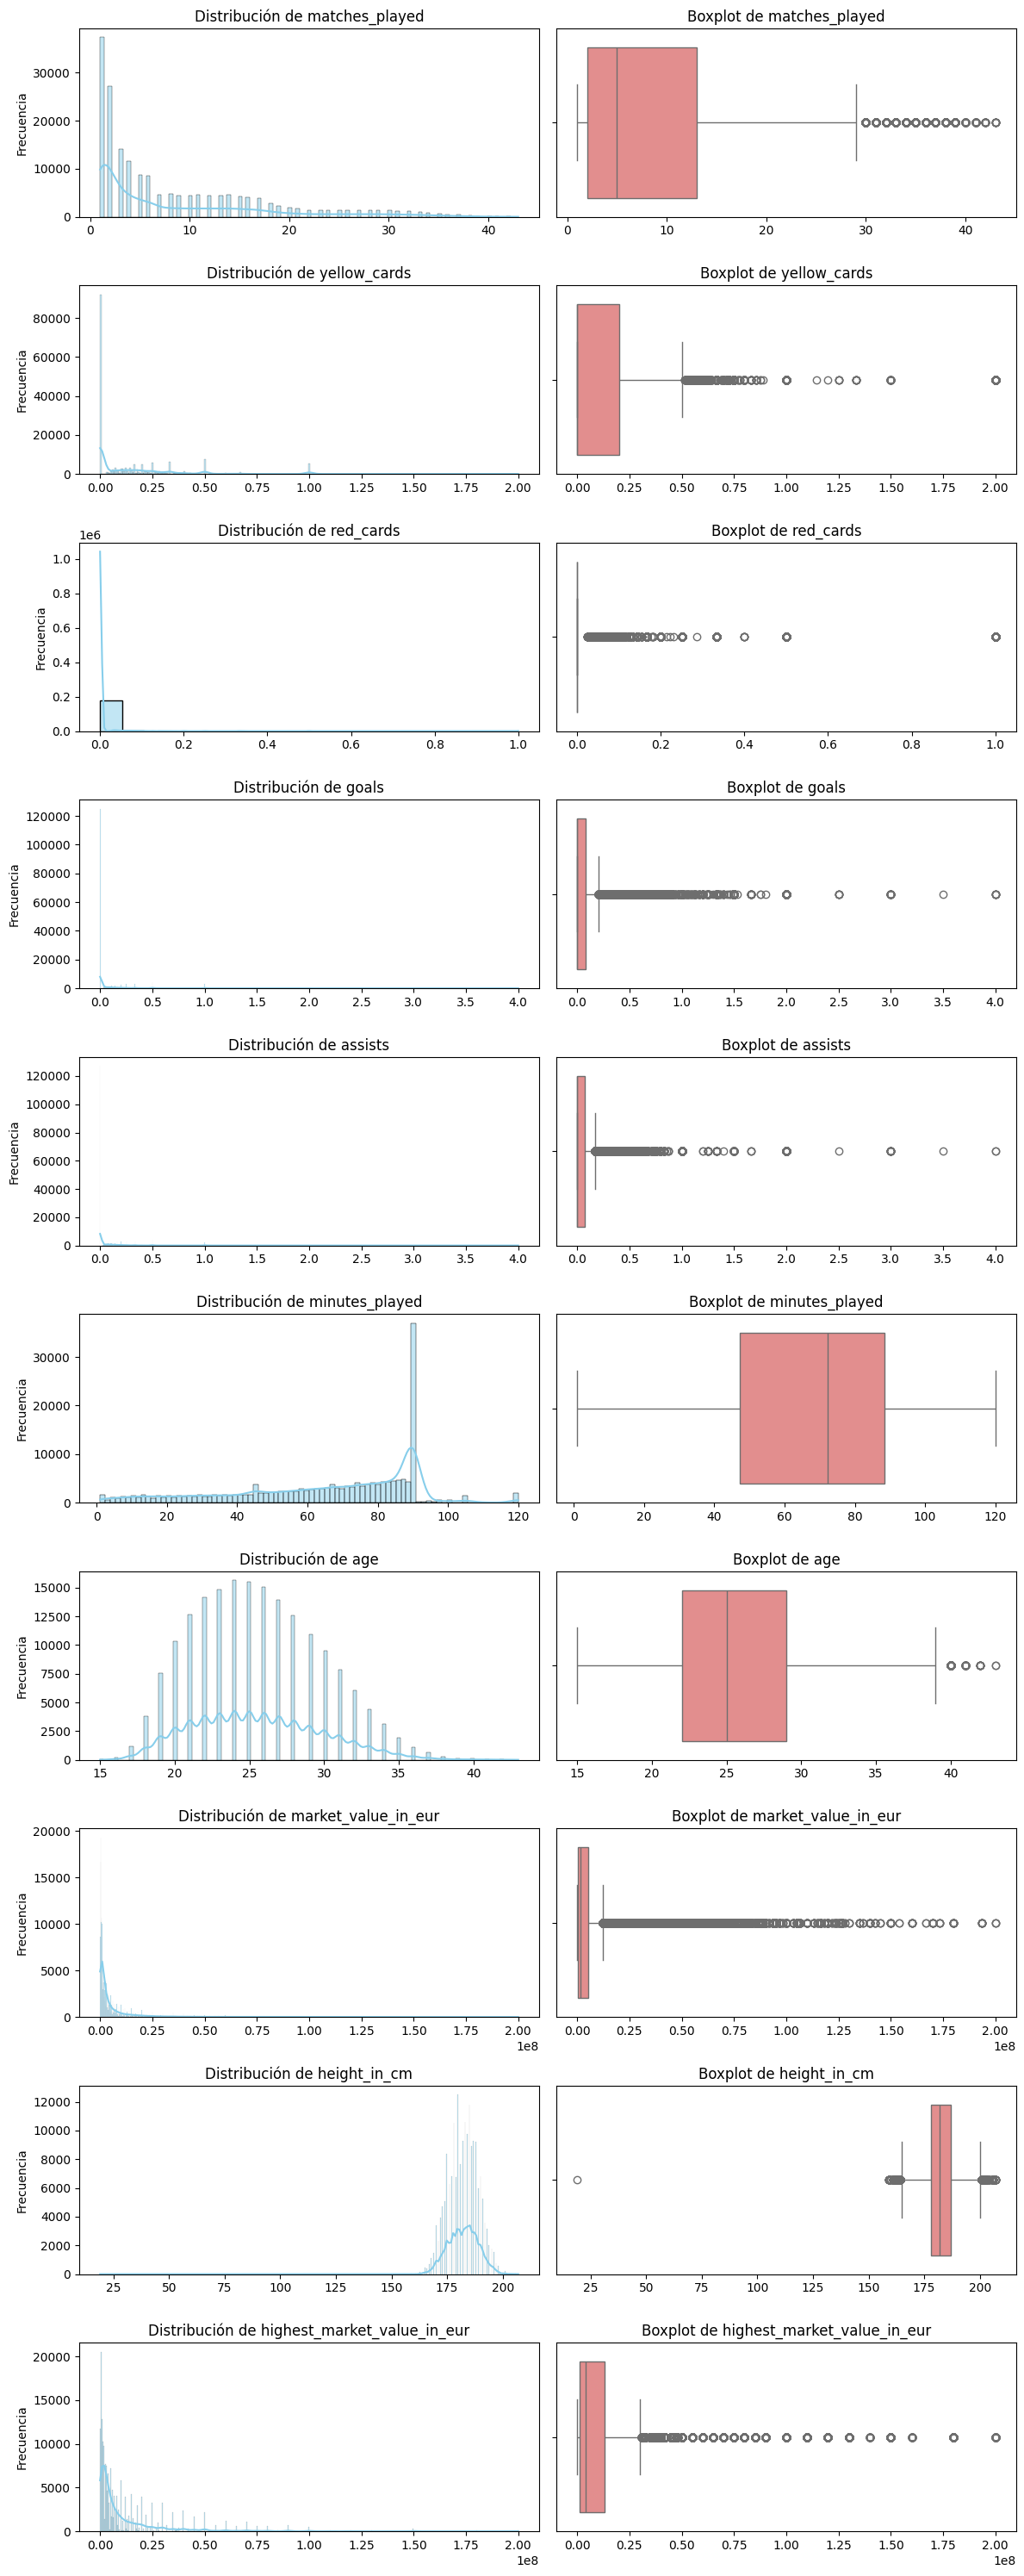

In [73]:
# Crear una figura con subplots
fig, axes = plt.subplots(len(numerical_columns), 2, figsize=(12, len(numerical_columns) * 3), 
                         gridspec_kw={'height_ratios': [1] * len(numerical_columns)})

# Iterar por cada variable y generar gráficos
for i, var in enumerate(numerical_columns):
    # Histograma
    sns.histplot(ax=axes[i, 0], data=df, x=var, kde=True, color='skyblue')
    axes[i, 0].set(title=f"Distribución de {var}", xlabel=None, ylabel="Frecuencia")
    
    # Boxplot
    sns.boxplot(ax=axes[i, 1], data=df, x=var, color='lightcoral')
    axes[i, 1].set(title=f"Boxplot de {var}", xlabel=None, ylabel=None)

# Ajustar diseño
plt.tight_layout()
plt.show()

Podemos observar que en todas las variables, los outliers no son datos erroneos, entran en los parámetros esperados (excepto la altura menor a 150 cm).

In [74]:
df[df["height_in_cm"] < 150]

,competition_id,club_name,matches_played,yellow_cards,red_cards,goals,assists,minutes_played,age,market_value_in_eur,country_of_birth,city_of_birth,sub_position,position,foot,height_in_cm,highest_market_value_in_eur
179437,SC1,Motherwell Football Club,10,0.2,0.0,0.0,0.0,62.6,26,250000.0,England,Reading,Left-Back,Defender,left,19.0,350000.0


In [75]:
df.loc[df['height_in_cm'] == 19, 'height_in_cm'] = 190

# Análisis por jugador (Messi)

In [76]:
messi=df_merge[df_merge['player_id'] == 28003]
messi.head()

,player_id,year,competition_id,club_name,player_name,matches_played,yellow_cards,red_cards,goals,assists,...,market_value_in_eur,country_of_birth,city_of_birth,country_of_citizenship,date_of_birth,sub_position,position,foot,height_in_cm,highest_market_value_in_eur
18799,28003,2012,CDR,Futbol Club Barcelona,Lionel Messi,1,0.000000,0.0,2.000000,0.000000,...,110000000.0,Argentina,Rosario,Argentina,1987-06-24 00:00:00,Right Winger,Attack,left,170.0,180000000.0
18800,28003,2012,CL,Futbol Club Barcelona,Lionel Messi,6,0.000000,0.0,0.833333,0.500000,...,110000000.0,Argentina,Rosario,Argentina,1987-06-24 00:00:00,Right Winger,Attack,left,170.0,180000000.0
18801,28003,2012,ES1,Futbol Club Barcelona,Lionel Messi,17,0.058824,0.0,1.529412,0.352941,...,110000000.0,Argentina,Rosario,Argentina,1987-06-24 00:00:00,Right Winger,Attack,left,170.0,180000000.0
18802,28003,2012,SUC,Futbol Club Barcelona,Lionel Messi,2,0.000000,0.0,1.000000,0.000000,...,110000000.0,Argentina,Rosario,Argentina,1987-06-24 00:00:00,Right Winger,Attack,left,170.0,180000000.0
18803,28003,2013,CDR,Futbol Club Barcelona,Lionel Messi,4,0.250000,0.0,0.500000,0.250000,...,120000000.0,Argentina,Rosario,Argentina,1987-06-24 00:00:00,Right Winger,Attack,left,170.0,180000000.0


In [77]:
messi_player=players[players['player_id'] == 28003]
messi_player.head()

,player_id,first_name,last_name,name,last_season,current_club_id,player_code,country_of_birth,city_of_birth,country_of_citizenship,...,foot,height_in_cm,contract_expiration_date,agent_name,image_url,url,current_club_domestic_competition_id,current_club_name,market_value_in_eur,highest_market_value_in_eur
2347,28003,Lionel,Messi,Lionel Messi,2022,583,lionel-messi,Argentina,Rosario,Argentina,...,left,170.0,NaN,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/lionel-messi/p...,FR1,Paris Saint-Germain Football Club,35000000.0,180000000.0


In [78]:
messi_pl_val=player_valuations[player_valuations['player_id'] == 28003]
messi_pl_val.head()

,player_id,date,market_value_in_eur,current_club_id,player_club_domestic_competition_id
2248,28003,2004-12-20,3000000,583,FR1
4728,28003,2005-12-28,5000000,583,FR1
4959,28003,2006-01-20,15000000,583,FR1
9674,28003,2007-07-26,40000000,583,FR1
11042,28003,2007-09-12,60000000,583,FR1


varibles categoricas:

In [79]:

object_columns = df.select_dtypes(include=['object'])
categorical_columns = df.select_dtypes(include=['object']).columns
object_columns.head()

,competition_id,club_name,country_of_birth,city_of_birth,sub_position,position,foot
0,EL,Società Sportiva Lazio S.p.A.,Poland,Opole,Centre-Forward,Attack,right
1,ELQ,Società Sportiva Lazio S.p.A.,Poland,Opole,Centre-Forward,Attack,right
2,IT1,Società Sportiva Lazio S.p.A.,Poland,Opole,Centre-Forward,Attack,right
3,CIT,Società Sportiva Lazio S.p.A.,Poland,Opole,Centre-Forward,Attack,right
4,EL,Società Sportiva Lazio S.p.A.,Poland,Opole,Centre-Forward,Attack,right


In [80]:
df['competition_id'].value_counts()
df['club_name'].value_counts()
df['country_of_birth'].value_counts()
df['city_of_birth'].value_counts()
df['sub_position'].value_counts()
df['position'].value_counts()
df['foot'].value_counts()


foot
right    130071
left      45511
both       8025
Name: count, dtype: int64

In [81]:
df['competition_id'].value_counts(normalize=True) * 100


competition_id
EL      6.278083
IT1     5.095122
CL      4.823346
ES1     4.761801
FR1     4.604944
TR1     4.580980
GB1     4.397980
PO1     4.361489
NL1     3.961178
L1      3.908892
GR1     3.744955
RU1     3.590277
CDR     3.549429
BE1     3.453572
CIT     3.122975
ELQ     3.037466
UKR1    2.917645
GRP     2.861002
DFB     2.719940
FAC     2.599574
NLP     2.585413
RUP     2.523324
POCP    2.503173
SC1     2.346860
DK1     2.083799
UKRP    1.617585
DKP     1.599068
CLQ     1.465630
SFA     1.320211
ECLQ    0.880141
CGB     0.464035
SUC     0.281035
DFL     0.204785
RUSS    0.201517
SCI     0.200973
GBCS    0.200973
USC     0.196616
NLSC    0.179732
FRCH    0.178098
BESC    0.174830
POSU    0.174285
UKRS    0.140518
KLUB    0.106750
Name: proportion, dtype: float64

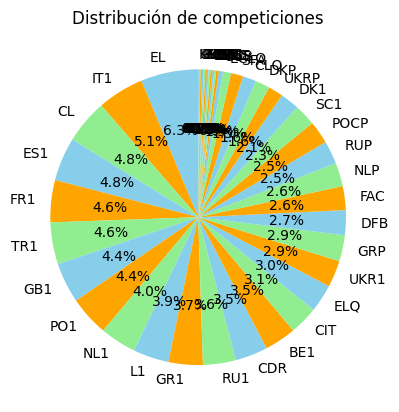

In [82]:
df['competition_id'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['skyblue', 'orange', 'lightgreen'])
plt.title("Distribución de competiciones")
plt.ylabel("")  # Ocultar el eje Y
plt.show()


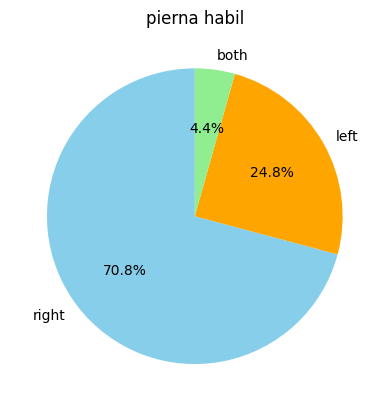

In [83]:
df['foot'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['skyblue', 'orange', 'lightgreen'])
plt.title("pierna habil")
plt.ylabel("")  # Ocultar el eje Y
plt.show()

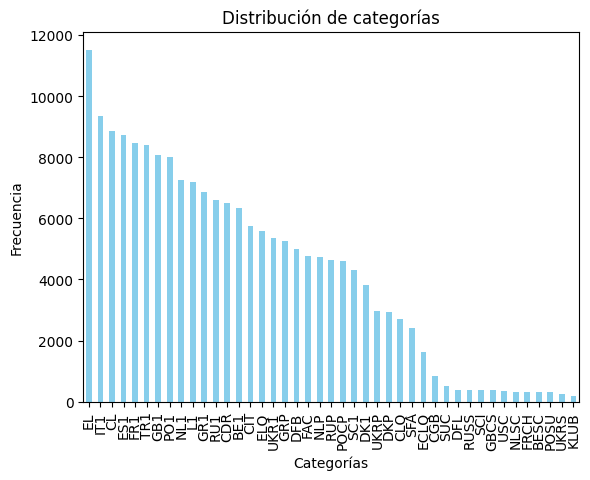

In [84]:
import matplotlib.pyplot as plt
df['competition_id'].value_counts().plot(kind='bar', color='skyblue')
plt.title("Distribución de categorías")
plt.xlabel("Categorías")
plt.ylabel("Frecuencia")
plt.show()


Frecuencia absoluta:
competition_id
EL      11527
IT1      9355
CL       8856
ES1      8743
FR1      8455
TR1      8411
GB1      8075
PO1      8008
NL1      7273
L1       7177
GR1      6876
RU1      6592
CDR      6517
BE1      6341
CIT      5734
ELQ      5577
UKR1     5357
GRP      5253
DFB      4994
FAC      4773
NLP      4747
RUP      4633
POCP     4596
SC1      4309
DK1      3826
UKRP     2970
DKP      2936
CLQ      2691
SFA      2424
ECLQ     1616
CGB       852
SUC       516
DFL       376
RUSS      370
SCI       369
GBCS      369
USC       361
NLSC      330
FRCH      327
BESC      321
POSU      320
UKRS      258
KLUB      196
Name: count, dtype: int64


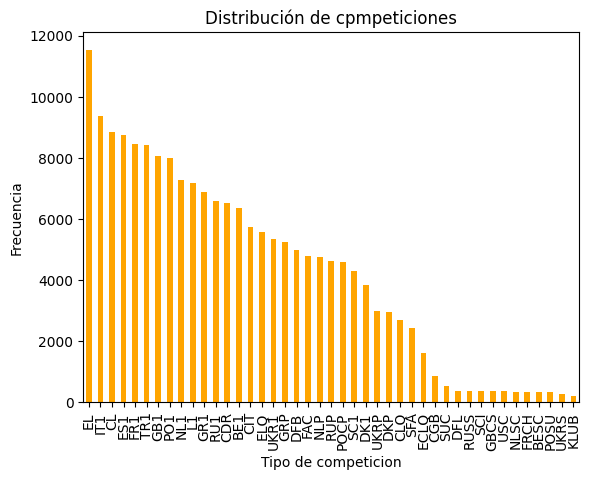


Frecuencia relativa (%):
competition_id
EL      6.278083
IT1     5.095122
CL      4.823346
ES1     4.761801
FR1     4.604944
TR1     4.580980
GB1     4.397980
PO1     4.361489
NL1     3.961178
L1      3.908892
GR1     3.744955
RU1     3.590277
CDR     3.549429
BE1     3.453572
CIT     3.122975
ELQ     3.037466
UKR1    2.917645
GRP     2.861002
DFB     2.719940
FAC     2.599574
NLP     2.585413
RUP     2.523324
POCP    2.503173
SC1     2.346860
DK1     2.083799
UKRP    1.617585
DKP     1.599068
CLQ     1.465630
SFA     1.320211
ECLQ    0.880141
CGB     0.464035
SUC     0.281035
DFL     0.204785
RUSS    0.201517
SCI     0.200973
GBCS    0.200973
USC     0.196616
NLSC    0.179732
FRCH    0.178098
BESC    0.174830
POSU    0.174285
UKRS    0.140518
KLUB    0.106750
Name: proportion, dtype: float64

Número de categorías únicas: 43


In [85]:
# todo junto
# Recuento de frecuencias
frecuencias = df['competition_id'].value_counts()
print("Frecuencia absoluta:")
print(frecuencias)

# Visualización
frecuencias.plot(kind='bar', color='orange')
plt.title("Distribución de cpmpeticiones")
plt.xlabel("Tipo de competicion")
plt.ylabel("Frecuencia")
plt.show()

# Frecuencia relativa
frecuencia_relativa = df['competition_id'].value_counts(normalize=True) * 100
print("\nFrecuencia relativa (%):")
print(frecuencia_relativa)

# Número de categorías únicas
print("\nNúmero de categorías únicas:", df['competition_id'].nunique())


### Análisis multivariado

Variables Numéricas:

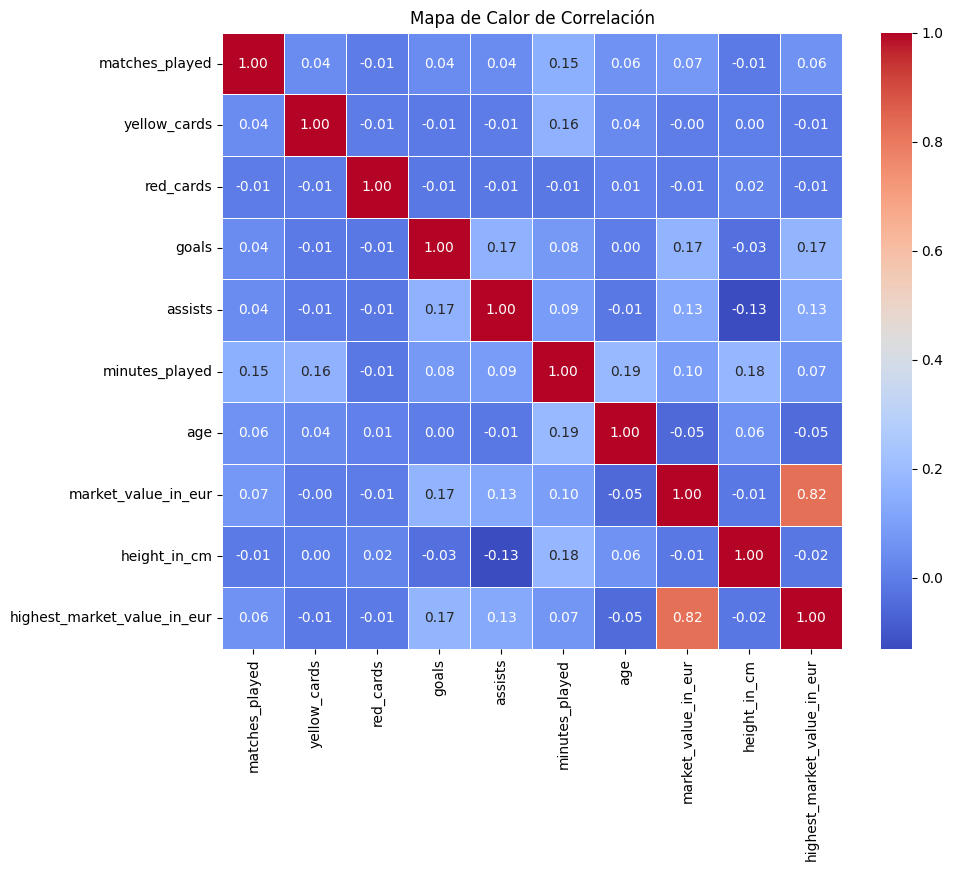

In [86]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrar solo las columnas numéricas
df_numerico = df.select_dtypes(include=['float64', 'int64'])

# Calcular la matriz de correlación
correlacion = df_numerico.corr()

# Crear el mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlacion, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Mapa de Calor de Correlación")
plt.show()


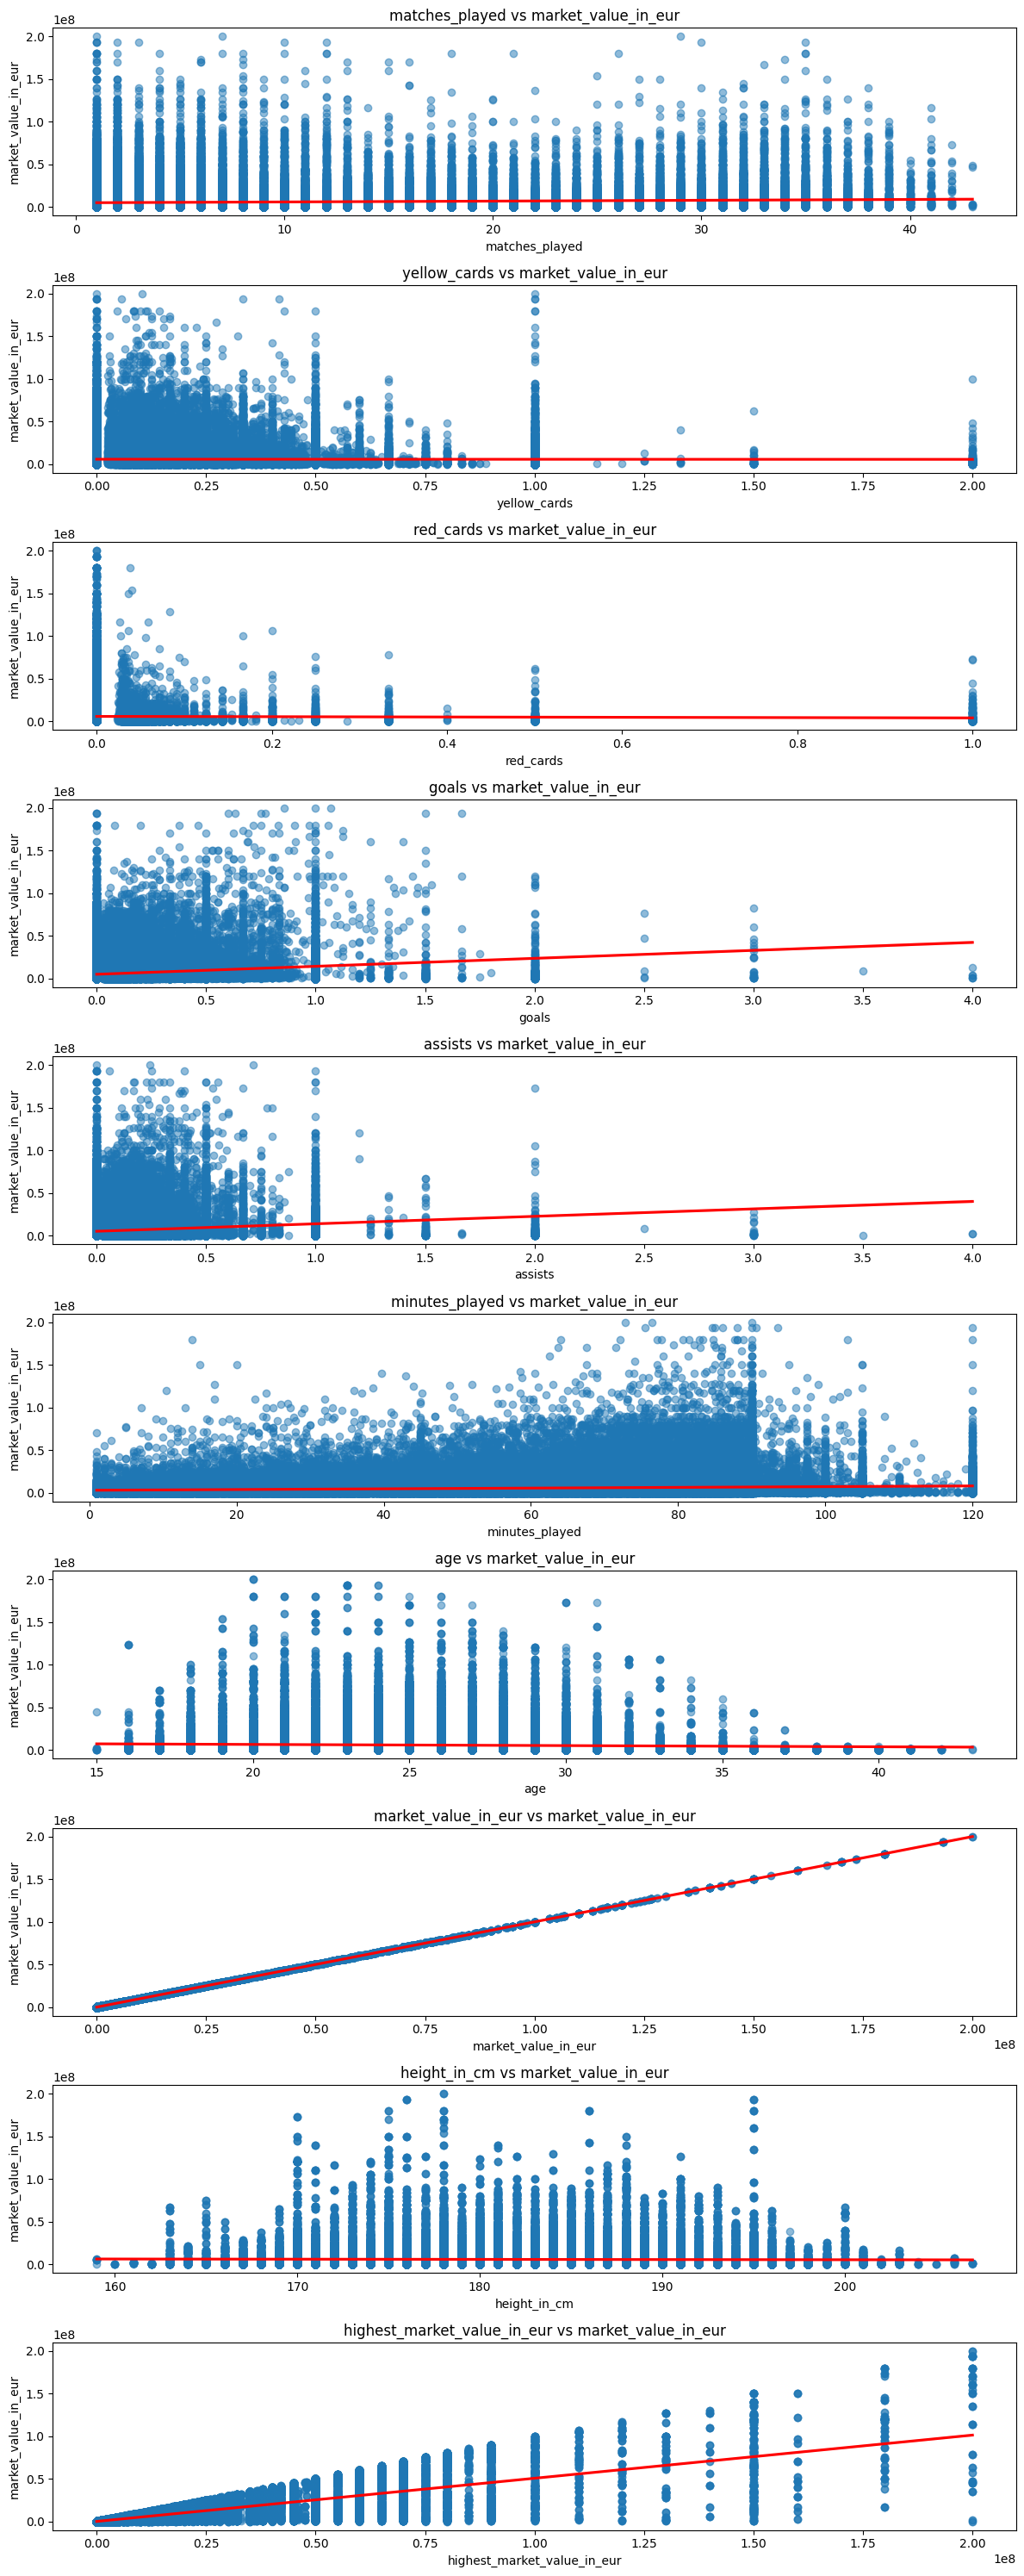

In [87]:
# Crear subplots
fig, axis = plt.subplots(figsize=(12, len(numerical_columns) * 3), nrows=len(numerical_columns), ncols=1)

# Iterar por cada variable numérica y graficar
for i, var in enumerate(numerical_columns):
    sns.regplot(ax=axis[i], data=df[numerical_columns], x=var, y="market_value_in_eur", scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
    axis[i].set_title(f"{var} vs market_value_in_eur", fontsize=12)
    axis[i].set_xlabel(var)
    axis[i].set_ylabel("market_value_in_eur")

# Ajustar el layout
plt.tight_layout()
plt.show()

variables categoricas

In [88]:
pd.crosstab(df['competition_id'], df['country_of_birth'])


country_of_birth,Albania,Algeria,Angola,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahrain,Belarus,...,United States,Uruguay,Uzbekistan,Venezuela,Vietnam,Wales,Yugoslavia (Republic),Zaire,Zambia,Zimbabwe
competition_id,,,,,,,,,,,,,,,,,,,,,
BE1,7,33,32,38,1,21,16,0,2,2,...,61,28,0,15,1,2,85,116,9,19
BESC,0,0,2,4,0,1,0,0,0,0,...,6,1,0,1,0,0,5,11,0,0
CDR,3,2,17,389,2,5,9,0,0,0,...,19,143,0,35,0,6,43,1,0,2
CGB,0,2,0,18,0,5,4,0,0,0,...,10,7,0,0,0,9,5,0,0,1
CIT,27,4,14,360,0,5,31,0,0,0,...,14,113,4,21,0,2,79,4,3,0
CL,9,11,14,371,0,11,88,0,0,2,...,49,116,2,14,0,35,48,15,3,1
CLQ,4,2,6,69,1,10,13,0,0,1,...,8,17,0,4,0,9,16,11,6,1
DFB,1,13,2,54,5,20,222,0,0,0,...,51,4,8,6,0,0,44,8,0,1
DFL,0,0,0,1,0,1,11,0,0,0,...,2,0,0,0,0,0,2,0,0,0


In [89]:
from scipy.stats import chi2_contingency

tabla = pd.crosstab(df['competition_id'], df['foot'])
chi2, p, dof, expected = chi2_contingency(tabla)
print("Estadístico Chi-cuadrado:", chi2)
print("Valor p:", p)


Estadístico Chi-cuadrado: 1730.3921482957985
Valor p: 1.4738195323661334e-305


In [90]:
from scipy.stats import chi2_contingency

tablas = pd.crosstab(df['competition_id'], df['country_of_birth'])
chi2, p, dof, expected = chi2_contingency(tabla)
print("Estadístico Chi-cuadrado:", chi2)
print("Valor p:", p)


Estadístico Chi-cuadrado: 1730.3921482957985
Valor p: 1.4738195323661334e-305


p-valor es menor a 0.05 se concluye que existe una asociación significativa

Tabla de contingencia:
foot            both  left  right
competition_id                   
BE1              156  1602   4583
BESC               5    71    245
CDR              193  1758   4566
CGB               23   232    597
CIT              224  1450   4060
CL               358  2196   6302
CLQ              118   631   1942
DFB              164  1150   3680
DFL               10    70    296
DK1              314   931   2581
DKP              231   714   1991
ECLQ              62   449   1105
EL               483  2834   8210
ELQ              289  1332   3956
ES1              227  2363   6153
FAC              158  1172   3443
FR1              185  2139   6131
FRCH               9    86    232
GB1              270  2006   5799
GBCS              12    98    259
GR1              507  1692   4677
GRP              391  1261   3601
IT1              361  2463   6531
KLUB               3    49    144
L1               284  1643   5250
NL1              319  1963   4991
NLP              194  128

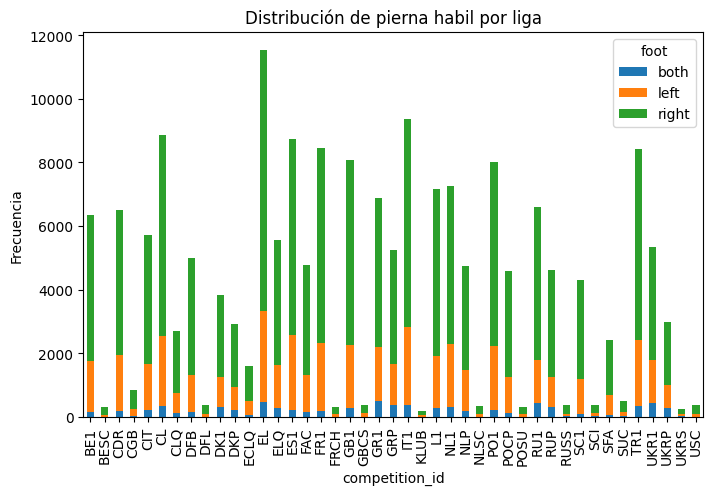

In [91]:



tabla = pd.crosstab(df['competition_id'], df['foot'])
print("Tabla de contingencia:")
print(tabla)

# Prueba de Chi-cuadrado
chi2, p, dof, expected = chi2_contingency(tabla)
print(f"\nChi-cuadrado: {chi2}, p-valor: {p}")

# Gráfico de barras apiladas
tabla.plot(kind='bar', stacked=True, figsize=(8, 5))
plt.title("Distribución de pierna habil por liga")
plt.xlabel("competition_id")
plt.ylabel("Frecuencia")
plt.show()

Análisis de variables categóricas vs variable objetivo

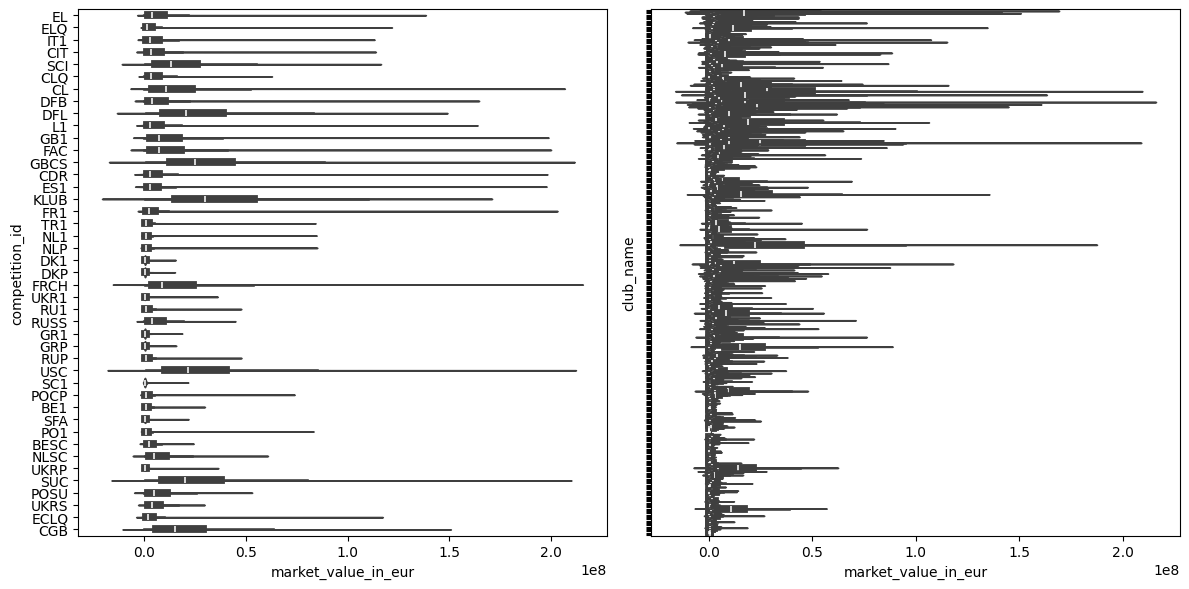

In [92]:
fig, axis = plt.subplots(figsize = (12, 6), ncols = 2)

sns.violinplot(ax = axis[0], data = df, x = "market_value_in_eur", y = "competition_id")
sns.violinplot(ax = axis[1], data = df, x = "market_value_in_eur", y = "club_name")

# Eliminar etiquetas en el eje Y para club_name
axis[1].set_yticklabels([])

plt.tight_layout()

plt.show()

Podemos observar que los jugadores que juegan en determinadas competencias, y los que pertenecen a determinados clubes influye en la valuación del mercado.

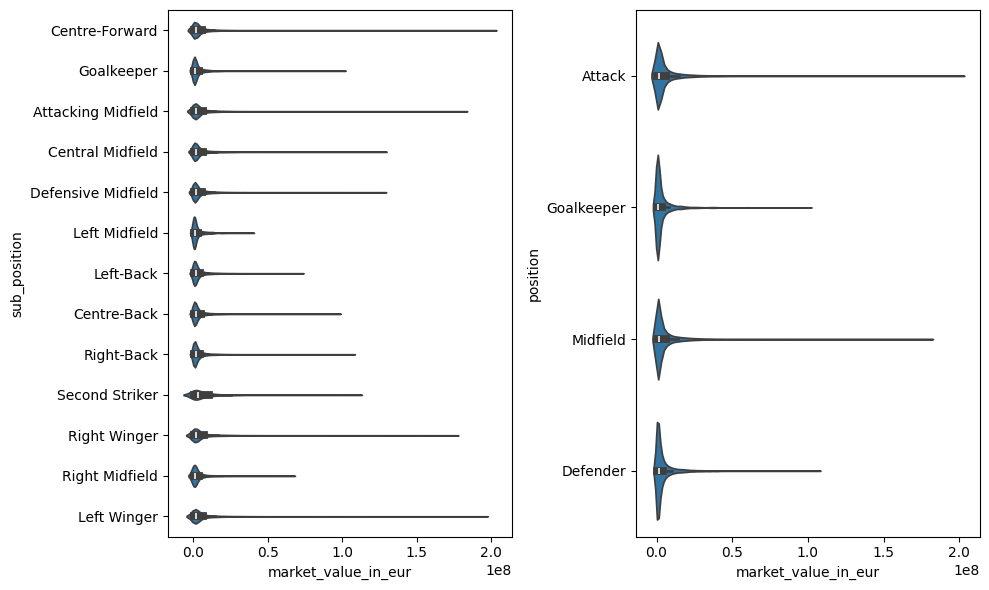

In [93]:
fig, axis = plt.subplots(figsize = (10, 6), ncols = 2)

sns.violinplot(ax = axis[0], data = df, x = "market_value_in_eur", y = "sub_position")
sns.violinplot(ax = axis[1], data = df, x = "market_value_in_eur", y = "position")


plt.tight_layout()

plt.show()

Observamos que la posición de los jugadores puede influir en el valor de mercado. 

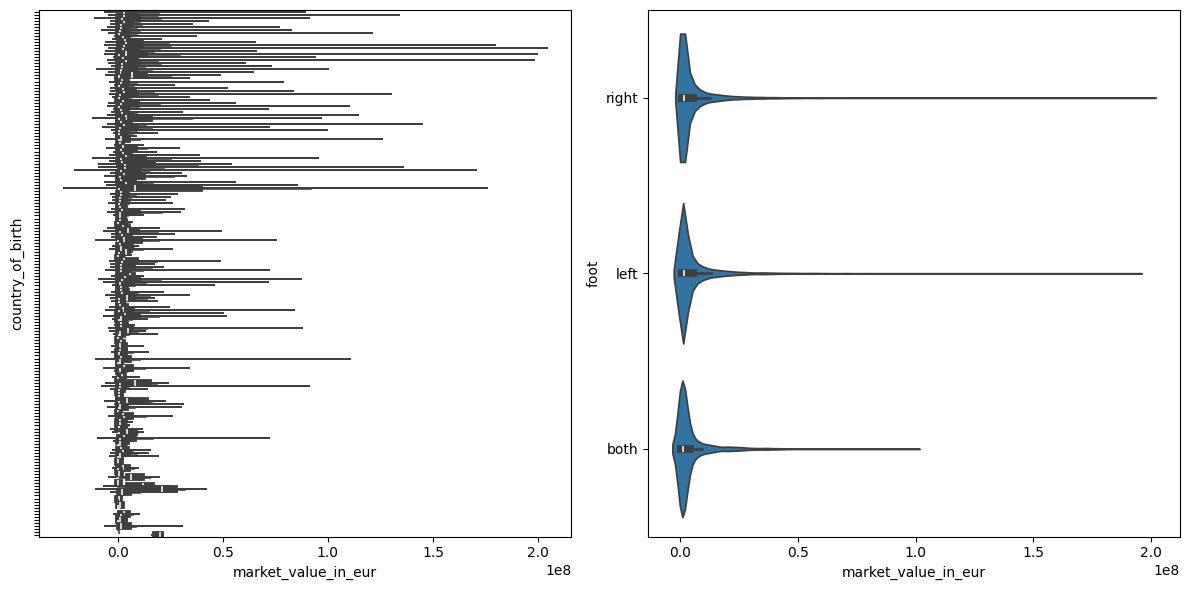

In [94]:
fig, axis = plt.subplots(figsize = (12, 6), ncols = 2)

sns.violinplot(ax = axis[0], data = df, x = "market_value_in_eur", y = "country_of_birth")
sns.violinplot(ax = axis[1], data = df, x = "market_value_in_eur", y = "foot")

# Eliminar etiquetas en el eje Y para club_name
axis[0].set_yticklabels([])

plt.tight_layout()

plt.show()

Observamos que el país de nacimiento influye en la valuación del mercado, mientras que el pie hábil del jugador no lo hace.

### Ingeniería de atributos

In [95]:
# Dividimos el conjunto de datos en muestras de train y test
X = df.drop("market_value_in_eur", axis = 1)
y = df["market_value_in_eur"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print(f"El tamaño de X_train: {X_train.shape}; mientras que el tamaño de X_test:{X_test.shape}")

El tamaño de X_train: (146885, 16); mientras que el tamaño de X_test:(36722, 16)


In [96]:
X_train.to_csv('/workspaces/proyecto_final_transfer/data/datos_de_transfer/proyecto final/X_train.csv', index=False)
X_test.to_csv('/workspaces/proyecto_final_transfer/data/datos_de_transfer/proyecto final/X_test.csv', index=False)

In [97]:
print(categorical_columns)

Index(['competition_id', 'club_name', 'country_of_birth', 'city_of_birth',
       'sub_position', 'position', 'foot'],
      dtype='object')


encod

In [98]:
X_train_cat_le = X_train.copy()
X_test_cat_le = X_test.copy()


X_full = pd.concat([X_train['city_of_birth'], X_test['city_of_birth']], axis=0)

# Entrenamos LabelEncoder con todos los datos
label_encoder_city_of_birth = LabelEncoder()
label_encoder_city_of_birth.fit(X_full)

# Aplicamos la transformación
X_train_cat_le['city_of_birth_le'] = label_encoder_city_of_birth.transform(X_train['city_of_birth'])
X_test_cat_le['city_of_birth_le'] = label_encoder_city_of_birth.transform(X_test['city_of_birth'])


In [99]:
X_full2 = pd.concat([X_train['country_of_birth'], X_test['country_of_birth']], axis=0)

# Entrenamos LabelEncoder con todos los datos
label_encoder_country_of_birth = LabelEncoder()
label_encoder_country_of_birth.fit(X_full2)

# Aplicamos la transformación
X_train_cat_le['country_of_birth_le'] = label_encoder_country_of_birth.transform(X_train['country_of_birth'])
X_test_cat_le['country_of_birth_le'] = label_encoder_country_of_birth.transform(X_test['country_of_birth'])
X_train_cat_le

,competition_id,club_name,matches_played,yellow_cards,red_cards,goals,assists,minutes_played,age,country_of_birth,city_of_birth,sub_position,position,foot,height_in_cm,highest_market_value_in_eur,city_of_birth_le,country_of_birth_le
125094,GR1,Panetolikos Agrinio,6,0.000000,0.0,0.000000,0.000000,10.833333,19,Greece,Amfilochia,Right-Back,Defender,right,185.0,750000.0,241,59
91301,EL,Association sportive de Saint-Étienne Loire,5,0.000000,0.0,0.000000,0.000000,69.800000,24,Guinea,Conakry,Centre-Back,Defender,left,189.0,4500000.0,1487,63
9211,TR1,Antalyaspor,24,0.166667,0.0,0.208333,0.166667,65.458333,34,Poland,Gliwice,Attacking Midfield,Midfield,left,182.0,23000000.0,2292,123
40671,L1,RasenBallsport Leipzig,13,0.076923,0.0,0.076923,0.000000,55.307692,27,Germany,Mutlangen,Central Midfield,Midfield,right,172.0,3000000.0,4155,57
164602,PO1,Futebol Clube de Famalicão,13,0.384615,0.0,0.000000,0.000000,34.230769,22,Portugal,Lisboa,Attacking Midfield,Midfield,left,190.0,800000.0,3553,124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125303,GRP,Apollon Smyrnis,2,0.000000,0.0,0.000000,0.000000,90.000000,24,Croatia,Nova Gradiška,Centre-Back,Defender,right,190.0,800000.0,4386,33
108340,RU1,FK Nizhny Novgorod,15,0.200000,0.0,0.066667,0.066667,55.533333,29,Russia,Astrakhan,Centre-Forward,Attack,right,183.0,800000.0,422,127
137920,GRP,Panetolikos Agrinio,3,0.000000,0.0,0.000000,0.000000,90.000000,19,Greece,Rhodes,Central Midfield,Midfield,left,181.0,300000.0,5150,59
153615,DKP,Fodbold Club Midtjylland,1,0.000000,0.0,0.000000,0.000000,25.000000,20,Nigeria,Oyo,Right Winger,Attack,right,178.0,2600000.0,4625,113


In [100]:
#LE PONGO # PORQUE EL ANTERIOR NO TIRA ERROR.

#import numpy as np
#from sklearn.preprocessing import LabelEncoder

# Instancio los LabelEncoders
#label_encoder_city_of_birth = LabelEncoder()

# Entreno el encoder con X_train
#X_train_cat_le['city_of_birth_le'] = label_encoder_city_of_birth.fit_transform(X_train['city_of_birth'])

# Mapeo los valores conocidos
#city_mapping = dict(zip(label_encoder_city_of_birth.classes_, label_encoder_city_of_birth.transform(label_encoder_city_of_birth.classes_)))

# Transformo X_test, asignando -1 a valores desconocidos
#X_test_cat_le['city_of_birth_le'] = X_test['city_of_birth'].map(city_mapping).fillna(-1).astype(int)


In [101]:

# Instancio los LabelEncoders
label_encoder_competition_id = LabelEncoder()
label_encoder_club_name = LabelEncoder()
#label_encoder_country_of_birth = LabelEncoder()
label_encoder_foot = LabelEncoder()
label_encoder_position = LabelEncoder()
label_encoder_sub_position = LabelEncoder()
#label_encoder_city_of_birth = LabelEncoder()

# Entreno los LabelEncoders con los datos de entrenamiento
label_encoder_competition_id.fit(X_train['competition_id'])
label_encoder_club_name.fit(X_train['club_name'])
#label_encoder_country_of_birth.fit(X_train['country_of_birth'])
label_encoder_foot.fit(X_train['foot'])
label_encoder_position.fit(X_train['position'])
label_encoder_sub_position.fit(X_train['sub_position'])
#label_encoder_city_of_birth.fit(X_train['city_of_birth'])

# Aplico el encoder en X_train
X_train_cat_le['competition_id_le'] = label_encoder_competition_id.transform(X_train['competition_id'])
X_train_cat_le['club_name_le'] = label_encoder_club_name.transform(X_train['club_name'])
#X_train_cat_le['country_of_birth_le'] = label_encoder_country_of_birth.transform(X_train['country_of_birth'])
X_train_cat_le['foot_le'] = label_encoder_foot.transform(X_train['foot'])
X_train_cat_le['position_le'] = label_encoder_position.transform(X_train['position'])
X_train_cat_le['sub_position_le'] = label_encoder_sub_position.transform(X_train['sub_position'])
#X_train_cat_le['city_of_birth_le'] = label_encoder_city_of_birth.transform(X_train['city_of_birth'])

# Aplico el encoder en X_test
X_test_cat_le['competition_id_le'] = label_encoder_competition_id.transform(X_test['competition_id'])
X_test_cat_le['club_name_le'] = label_encoder_club_name.transform(X_test['club_name'])
#X_test_cat_le['country_of_birth_le'] = label_encoder_country_of_birth.transform(X_test['country_of_birth'])
X_test_cat_le['foot_le'] = label_encoder_foot.transform(X_test['foot'])
X_test_cat_le['position_le'] = label_encoder_position.transform(X_test['position'])
X_test_cat_le['sub_position_le'] = label_encoder_sub_position.transform(X_test['sub_position'])
#X_test_cat_le['city_of_birth_le'] = label_encoder_city_of_birth.transform(X_test['city_of_birth'])

# Dataset X_train, X_test con las variables categóricas codificadas:
X_train_cat=X_train_cat_le[['competition_id_le','club_name_le','foot_le','position_le','sub_position_le','country_of_birth_le','city_of_birth_le']]
X_test_cat=X_test_cat_le[['competition_id_le','club_name_le','foot_le','position_le','sub_position_le','country_of_birth_le','city_of_birth_le']]

# Muestra las primeras filas
X_train_cat.head()


,competition_id_le,club_name_le,foot_le,position_le,sub_position_le,country_of_birth_le,city_of_birth_le
125094,20,299,2,1,11,59,241
91301,12,48,1,1,2,63,1487
9211,38,37,1,3,0,123,2292
40671,24,319,2,3,1,57,4155
164602,28,190,1,3,0,124,3553


Escalado de variables numéricas (Normalización):

In [102]:
# Variables númericas sin el objetivo:
num_colum=X.select_dtypes(include=['number']).columns

# instancio el escalador Normalización
scaler = StandardScaler()

# entreno el escalador con los datos de entrenamiento
scaler.fit(X_train[num_colum])

# aplico el escalador en ambos
X_train_num_scal = scaler.transform(X_train[num_colum])
X_train_num_scal = pd.DataFrame(X_train_num_scal, index = X_train.index, columns = num_colum)

X_test_num_scal = scaler.transform(X_test[num_colum])
X_test_num_scal = pd.DataFrame(X_test_num_scal, index = X_test.index, columns = num_colum)

X_train_num_scal.head()

,matches_played,yellow_cards,red_cards,goals,assists,minutes_played,age,height_in_cm,highest_market_value_in_eur
125094,-0.285854,-0.632853,-0.099458,-0.425541,-0.410126,-2.067374,-1.517053,0.422396,-0.562580
91301,-0.399379,-0.632853,-0.099458,-0.425541,-0.410126,0.176365,-0.354822,1.024731,-0.364459
9211,1.757587,0.123016,-0.099458,0.585865,0.577026,0.011160,1.969642,-0.029355,0.612937
40671,0.508817,-0.283990,-0.099458,-0.052099,-0.410126,-0.375082,0.342518,-1.535192,-0.443707
164602,0.508817,1.111461,-0.099458,-0.425541,-0.410126,-1.177079,-0.819714,1.175314,-0.559938


Escalado de variables numéricas (Min-Max)

In [103]:
# instancio el escalador Min-Max
scaler_mm = MinMaxScaler()

# entreno el escalador con los datos de entrenamiento
scaler_mm.fit(X_train[num_colum])

# aplico el escalador en ambos

X_train_num_mm = scaler_mm.transform(X_train[num_colum])
X_train_num_mm = pd.DataFrame(X_train_num_mm, index = X_train.index, columns = num_colum)

X_test_num_mm = scaler_mm.transform(X_test[num_colum])
X_test_num_mm = pd.DataFrame(X_test_num_mm, index = X_test.index, columns = num_colum)

X_train_num_mm.head()

,matches_played,yellow_cards,red_cards,goals,assists,minutes_played,age,height_in_cm,highest_market_value_in_eur
125094,0.119048,0.000000,0.0,0.000000,0.000000,0.082633,0.142857,0.541667,0.003700
91301,0.095238,0.000000,0.0,0.000000,0.000000,0.578151,0.321429,0.625000,0.022451
9211,0.547619,0.083333,0.0,0.052083,0.041667,0.541667,0.678571,0.479167,0.114956
40671,0.285714,0.038462,0.0,0.019231,0.000000,0.456367,0.428571,0.270833,0.014951
164602,0.285714,0.192308,0.0,0.000000,0.000000,0.279250,0.250000,0.645833,0.003950


Unficado de variables categóricas y numéricas (separado en el escalado normalizado, min-max y sin escalar)

In [104]:
X_train[num_colum]

,matches_played,yellow_cards,red_cards,goals,assists,minutes_played,age,height_in_cm,highest_market_value_in_eur
125094,6,0.000000,0.0,0.000000,0.000000,10.833333,19,185.0,750000.0
91301,5,0.000000,0.0,0.000000,0.000000,69.800000,24,189.0,4500000.0
9211,24,0.166667,0.0,0.208333,0.166667,65.458333,34,182.0,23000000.0
40671,13,0.076923,0.0,0.076923,0.000000,55.307692,27,172.0,3000000.0
164602,13,0.384615,0.0,0.000000,0.000000,34.230769,22,190.0,800000.0
...,...,...,...,...,...,...,...,...,...
125303,2,0.000000,0.0,0.000000,0.000000,90.000000,24,190.0,800000.0
108340,15,0.200000,0.0,0.066667,0.066667,55.533333,29,183.0,800000.0
137920,3,0.000000,0.0,0.000000,0.000000,90.000000,19,181.0,300000.0
153615,1,0.000000,0.0,0.000000,0.000000,25.000000,20,178.0,2600000.0


In [105]:
#sin escalado
X_train_sin_esc = pd.concat([X_train[num_colum], X_train_cat], axis=1)
X_test_sin_esc = pd.concat([X_test[num_colum], X_test_cat], axis=1)
print(X_train_sin_esc.head())

#Escalado normalizado
X_train_scal = pd.concat([X_train_num_scal, X_train_cat], axis=1)
X_test_scal = pd.concat([X_test_num_scal, X_test_cat], axis=1)
print(X_train_scal.head())

#Escalado min-max
X_train_mm = pd.concat([X_train_num_mm, X_train_cat], axis=1)
X_test_mm = pd.concat([X_test_num_mm, X_test_cat], axis=1)
print(X_train_mm.head())



        matches_played  yellow_cards  red_cards     goals   assists  \
125094               6      0.000000        0.0  0.000000  0.000000   
91301                5      0.000000        0.0  0.000000  0.000000   
9211                24      0.166667        0.0  0.208333  0.166667   
40671               13      0.076923        0.0  0.076923  0.000000   
164602              13      0.384615        0.0  0.000000  0.000000   

        minutes_played  age  height_in_cm  highest_market_value_in_eur  \
125094       10.833333   19         185.0                     750000.0   
91301        69.800000   24         189.0                    4500000.0   
9211         65.458333   34         182.0                   23000000.0   
40671        55.307692   27         172.0                    3000000.0   
164602       34.230769   22         190.0                     800000.0   

        competition_id_le  club_name_le  foot_le  position_le  \
125094                 20           299        2            1  

Guardado de datos de train y test para modelar

In [106]:
X_train_sin_esc.to_csv('/workspaces/proyecto_final_transfer/data/datos_de_transfer/proyecto final/X_train_sin_esc.csv', index=False)
X_test_sin_esc.to_csv('/workspaces/proyecto_final_transfer/data/datos_de_transfer/proyecto final/X_test_sin_esc.csv', index=False)
X_train_scal.to_csv('/workspaces/proyecto_final_transfer/data/datos_de_transfer/proyecto final/X_train_scal.csv', index=False)
X_test_scal.to_csv('/workspaces/proyecto_final_transfer/data/datos_de_transfer/proyecto final/X_test_scal.csv', index=False)
X_train_mm.to_csv('/workspaces/proyecto_final_transfer/data/datos_de_transfer/proyecto final/X_train_mm.csv', index=False)
X_test_mm.to_csv('/workspaces/proyecto_final_transfer/data/datos_de_transfer/proyecto final/X_test_mm.csv', index=False)
y_train.to_csv('/workspaces/proyecto_final_transfer/data/datos_de_transfer/proyecto final/y_train.csv', index=False)
y_test.to_csv('/workspaces/proyecto_final_transfer/data/datos_de_transfer/proyecto final/y_test.csv', index=False)

### Ejecutar desde acá

In [107]:
X_train_sin_esc=pd.read_csv("/workspaces/proyecto_final_transfer/data/datos_de_transfer/proyecto final/X_train_sin_esc.csv")
X_test_sin_esc=pd.read_csv("/workspaces/proyecto_final_transfer/data/datos_de_transfer/proyecto final/X_test_sin_esc.csv")
y_train=pd.read_csv("/workspaces/proyecto_final_transfer/data/datos_de_transfer/proyecto final/y_train.csv")
y_test=pd.read_csv("/workspaces/proyecto_final_transfer/data/datos_de_transfer/proyecto final/y_test.csv")

In [108]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
# modelo
model = DecisionTreeRegressor(random_state = 42)
model.fit(X_train_sin_esc, y_train)

DecisionTreeRegressor(random_state=42)

In [109]:
y_pred_test = model.predict(X_test_sin_esc)
y_pred_test

array([2066666.66666667,  675000.        , 3500000.        , ...,
       4833333.33333333,  400000.        , 3950000.        ],
      shape=(36722,))

In [110]:
# metricas
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)

print("MSE Test: ", mse_test)
print("RMSE Test: ", rmse_test)

MSE Test:  23722345850806.77
RMSE Test:  4870559.090166833


In [111]:
model_arbol = DecisionTreeRegressor(random_state = 42)
#entrenamiento
model_arbol.fit(X_train_sin_esc, y_train)
# prediccion
y_pred_sin_esc_test = model_arbol.predict(X_test_sin_esc)
y_pred_sin_esc_train = model_arbol.predict(X_train_sin_esc)
# metricas Test
mse_l1_sin_esc_test = mean_squared_error(y_test, y_pred_sin_esc_test)
rmse_l1_sin_esc_test = np.sqrt(mse_l1_sin_esc_test)
r2_l1_sin_esc_test = r2_score(y_test, y_pred_sin_esc_test)
print("Las métricas para el conjunto test:")
print("MSE: ", mse_l1_sin_esc_test)
print("RMSE: ", rmse_l1_sin_esc_test)
print("Coeficiente de determinación: ", r2_l1_sin_esc_test)
# metricas train
mse_l1_sin_esc_train = mean_squared_error(y_train, y_pred_sin_esc_train)
rmse_l1_sin_esc_train = np.sqrt(mse_l1_sin_esc_train)
r2_l1_sin_esc_train = r2_score(y_train, y_pred_sin_esc_train)
print("Las métricas para el conjunto train:")
print("MSE: ", mse_l1_sin_esc_train)
print("RMSE: ", rmse_l1_sin_esc_train)
print("Coeficiente de determinación: ", r2_l1_sin_esc_train)

Las métricas para el conjunto test:
MSE:  23722345850806.77
RMSE:  4870559.090166833
Coeficiente de determinación:  0.8231184438815868
Las métricas para el conjunto train:
MSE:  5119040907.498496
RMSE:  71547.47310351706
Coeficiente de determinación:  0.999962341396976


Un gráfico de barras es útil para comparar los valores de MSE, RMSE y R² entre el conjunto de entrenamiento y prueba


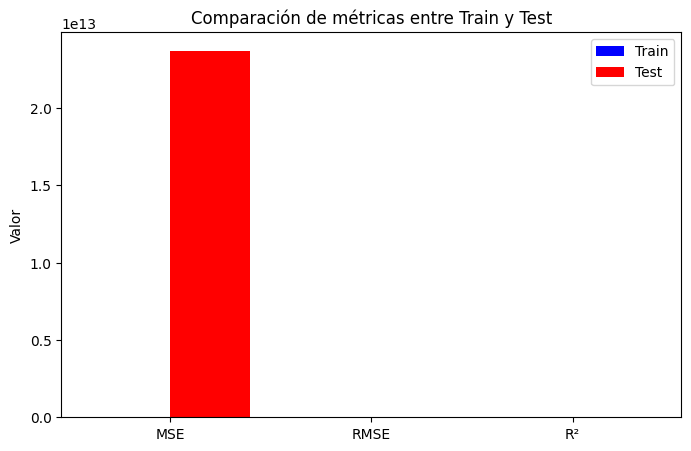

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns

# Datos para graficar
metricas = ["MSE", "RMSE", "R²"]
valores_train = [mse_l1_sin_esc_train, rmse_l1_sin_esc_train, r2_l1_sin_esc_train]
valores_test = [mse_l1_sin_esc_test, rmse_l1_sin_esc_test, r2_l1_sin_esc_test]

# Crear gráfico de barras
plt.figure(figsize=(8, 5))
x = range(len(metricas))
plt.bar(x, valores_train, width=0.4, label="Train", color="blue", align='center')
plt.bar([p + 0.4 for p in x], valores_test, width=0.4, label="Test", color="red", align='center')

# Etiquetas
plt.xticks([p + 0.2 for p in x], metricas)
plt.ylabel("Valor")
plt.title("Comparación de métricas entre Train y Test")
plt.legend()
plt.show()


Este gráfico ayuda a visualizar cómo de bien predice el modelo.
si el modelo es perfecto los puntos deberian estar sobre la linea roja

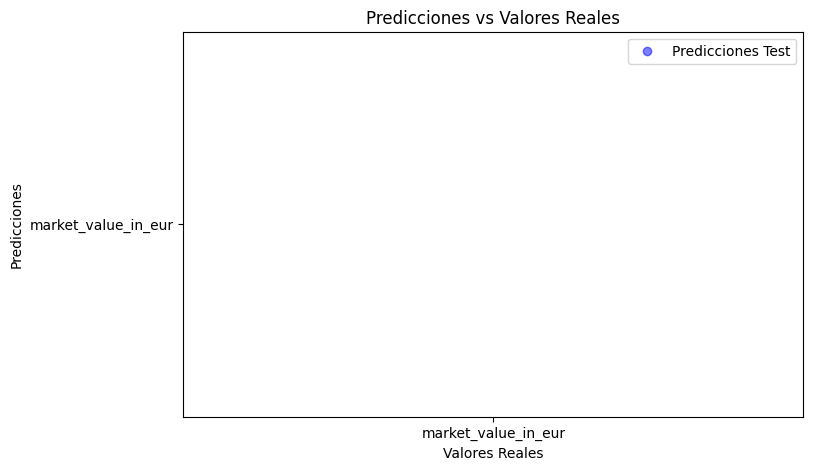

In [113]:
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred_sin_esc_test, color='blue', alpha=0.5, label="Predicciones Test")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='dashed', linewidth=2)
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Predicciones vs Valores Reales")
plt.legend()
plt.show()


Este gráfico muestra la distribución de los errores, útil para ver si el modelo tiene sesgo.

 Si el modelo es bueno, los errores deben estar centrados en 0 y tener una distribución simétrica

In [114]:
residuales = y_test - y_pred_sin_esc_test

plt.figure(figsize=(8, 5))
sns.histplot(residuales, kde=True, bins=30, color="purple")
plt.axvline(0, color='red', linestyle='dashed')
plt.xlabel("Error Residual")
plt.ylabel("Frecuencia")
plt.title("Distribución de Errores Residuales")
plt.show()


ValueError: Unable to coerce to Series, length must be 1: given 36722

##### Modelado sin hiperparámetros

In [4]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(random_state = 42, n_estimators = 50)
model.fit(X_train_sin_esc, y_train)

/home/vscode/.local/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(n_estimators=50, random_state=42)

In [5]:
# prediccion
y_pred_sin_esc_test = model.predict(X_test_sin_esc)
y_pred_sin_esc_train = model.predict(X_train_sin_esc)
# metricas Test
mse_l1_sin_esc_test = mean_squared_error(y_test, y_pred_sin_esc_test)
rmse_l1_sin_esc_test = np.sqrt(mse_l1_sin_esc_test)
r2_l1_sin_esc_test = r2_score(y_test, y_pred_sin_esc_test)
print("Las métricas para el conjunto test:")
print("MSE: ", mse_l1_sin_esc_test)
print("RMSE: ", rmse_l1_sin_esc_test)
print("Coeficiente de determinación: ", r2_l1_sin_esc_test)
# metricas train
mse_l1_sin_esc_train = mean_squared_error(y_train, y_pred_sin_esc_train)
rmse_l1_sin_esc_train = np.sqrt(mse_l1_sin_esc_train)
r2_l1_sin_esc_train = r2_score(y_train, y_pred_sin_esc_train)
print("Las métricas para el conjunto train:")
print("MSE: ", mse_l1_sin_esc_train)
print("RMSE: ", rmse_l1_sin_esc_train)
print("Coeficiente de determinación: ", r2_l1_sin_esc_train)

Las métricas para el conjunto test:
MSE:  12823277590263.307
RMSE:  3580960.4284693385
Coeficiente de determinación:  0.9043854554280091
Las métricas para el conjunto train:
MSE:  1951993581629.6863
RMSE:  1397137.6387563562
Coeficiente de determinación:  0.9856400148535253


##### Modelado cambiando hiperparámetros

In [14]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(
    n_estimators=50,
    max_depth=100,
    min_samples_split=4,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    random_state=42
)
model.fit(X_train_sin_esc, y_train)

/home/vscode/.local/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(max_depth=100, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=4, n_estimators=50, n_jobs=-1,
                      oob_score=True, random_state=42)

In [15]:
# prediccion
y_pred_sin_esc_test = model.predict(X_test_sin_esc)
y_pred_sin_esc_train = model.predict(X_train_sin_esc)
# metricas Test
mse_l1_sin_esc_test = mean_squared_error(y_test, y_pred_sin_esc_test)
rmse_l1_sin_esc_test = np.sqrt(mse_l1_sin_esc_test)
r2_l1_sin_esc_test = r2_score(y_test, y_pred_sin_esc_test)
print("Las métricas para el conjunto test:")
print("MSE: ", mse_l1_sin_esc_test)
print("RMSE: ", rmse_l1_sin_esc_test)
print("Coeficiente de determinación: ", r2_l1_sin_esc_test)
# metricas train
mse_l1_sin_esc_train = mean_squared_error(y_train, y_pred_sin_esc_train)
rmse_l1_sin_esc_train = np.sqrt(mse_l1_sin_esc_train)
r2_l1_sin_esc_train = r2_score(y_train, y_pred_sin_esc_train)
print("Las métricas para el conjunto train:")
print("MSE: ", mse_l1_sin_esc_train)
print("RMSE: ", rmse_l1_sin_esc_train)
print("Coeficiente de determinación: ", r2_l1_sin_esc_train)

Las métricas para el conjunto test:
MSE:  21439307281122.098
RMSE:  4630259.958266069
Coeficiente de determinación:  0.8401415248797272
Las métricas para el conjunto train:
MSE:  6621959857211.078
RMSE:  2573316.8979375777
Coeficiente de determinación:  0.9512850625714081


# Nueva prueba

El modelo da buena métrica, pero consideramos que el valor de RMSE es bastante alto. Evaluaremos el modelo para jugadores "promedios", aquellos que no tienen valuaciones tan altas ni tan bajas.

In [2]:
df=pd.read_csv("/workspaces/proyecto_final_transfer/data/datos_de_transfer/proyecto final/df_final_sin_nulos.csv")
print(df.shape)
categorical_columns = df.select_dtypes(include=['object']).columns
competition=pd.read_csv("/workspaces/proyecto_final_transfer/data/datos_de_transfer/proyecto final/competitions.csv")
df["market_value_in_eur"].describe()

(183607, 17)


count    1.836070e+05
mean     5.721055e+06
std      1.164345e+07
min      1.000000e+04
25%      5.500000e+05
50%      1.625000e+06
75%      5.250000e+06
max      2.000000e+08
Name: market_value_in_eur, dtype: float64

In [4]:
df_competition = competition[["competition_id", "name"]]


In [5]:
compe_merged = pd.merge(df,df_competition , on=['competition_id'], how='inner')
print(compe_merged.shape)
compe_merged

(183607, 18)


,competition_id,club_name,matches_played,yellow_cards,red_cards,goals,assists,minutes_played,age,market_value_in_eur,country_of_birth,city_of_birth,sub_position,position,foot,height_in_cm,highest_market_value_in_eur,name
0,EL,Società Sportiva Lazio S.p.A.,2,0.000000,0.0,0.000000,0.000000,52.000000,34,6000000.0,Poland,Opole,Centre-Forward,Attack,right,184.0,30000000.0,europa-league
1,ELQ,Società Sportiva Lazio S.p.A.,1,1.000000,0.0,1.000000,0.000000,83.000000,34,6000000.0,Poland,Opole,Centre-Forward,Attack,right,184.0,30000000.0,europa-league-qualifikation
2,IT1,Società Sportiva Lazio S.p.A.,17,0.294118,0.0,0.588235,0.058824,76.235294,34,6000000.0,Poland,Opole,Centre-Forward,Attack,right,184.0,30000000.0,serie-a
3,CIT,Società Sportiva Lazio S.p.A.,2,0.500000,0.0,0.000000,0.000000,80.000000,34,3000000.0,Poland,Opole,Centre-Forward,Attack,right,184.0,30000000.0,italy-cup
4,EL,Società Sportiva Lazio S.p.A.,3,0.333333,0.0,0.000000,0.000000,22.333333,34,3000000.0,Poland,Opole,Centre-Forward,Attack,right,184.0,30000000.0,europa-league
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183602,PO1,Boavista Futebol Clube,2,0.000000,0.0,0.000000,0.000000,16.000000,18,150000.0,Portugal,Porto,Left-Back,Defender,left,175.0,200000.0,liga-portugal-bwin
183603,PO1,Boavista Futebol Clube,6,0.000000,0.0,0.000000,0.000000,17.500000,18,150000.0,Portugal,Porto,Left Winger,Attack,right,184.0,150000.0,liga-portugal-bwin
183604,ES1,Real Club Deportivo Mallorca S.A.D.,3,0.000000,0.0,0.000000,0.000000,38.333333,17,500000.0,Spain,Llucmajor,Centre-Forward,Attack,left,182.0,500000.0,laliga
183605,DK1,Randers Fodbold Club,4,0.000000,0.0,0.000000,0.000000,9.750000,19,50000.0,Ghana,Techiman,Left Winger,Attack,both,164.0,50000.0,superligaen


In [6]:
compe_merged = compe_merged.drop(columns=['competition_id'])

print(compe_merged)

                                  club_name  matches_played  yellow_cards  \
0             Società Sportiva Lazio S.p.A.               2      0.000000   
1             Società Sportiva Lazio S.p.A.               1      1.000000   
2             Società Sportiva Lazio S.p.A.              17      0.294118   
3             Società Sportiva Lazio S.p.A.               2      0.500000   
4             Società Sportiva Lazio S.p.A.               3      0.333333   
...                                     ...             ...           ...   
183602               Boavista Futebol Clube               2      0.000000   
183603               Boavista Futebol Clube               6      0.000000   
183604  Real Club Deportivo Mallorca S.A.D.               3      0.000000   
183605                 Randers Fodbold Club               4      0.000000   
183606                 Randers Fodbold Club               2      0.500000   

        red_cards     goals   assists  minutes_played  age  \
0            

In [7]:
df = compe_merged.rename(columns={'name': 'competition_id'})
df=df.drop(columns= ["city_of_birth"])
df

,club_name,matches_played,yellow_cards,red_cards,goals,assists,minutes_played,age,market_value_in_eur,country_of_birth,sub_position,position,foot,height_in_cm,highest_market_value_in_eur,competition_id
0,Società Sportiva Lazio S.p.A.,2,0.000000,0.0,0.000000,0.000000,52.000000,34,6000000.0,Poland,Centre-Forward,Attack,right,184.0,30000000.0,europa-league
1,Società Sportiva Lazio S.p.A.,1,1.000000,0.0,1.000000,0.000000,83.000000,34,6000000.0,Poland,Centre-Forward,Attack,right,184.0,30000000.0,europa-league-qualifikation
2,Società Sportiva Lazio S.p.A.,17,0.294118,0.0,0.588235,0.058824,76.235294,34,6000000.0,Poland,Centre-Forward,Attack,right,184.0,30000000.0,serie-a
3,Società Sportiva Lazio S.p.A.,2,0.500000,0.0,0.000000,0.000000,80.000000,34,3000000.0,Poland,Centre-Forward,Attack,right,184.0,30000000.0,italy-cup
4,Società Sportiva Lazio S.p.A.,3,0.333333,0.0,0.000000,0.000000,22.333333,34,3000000.0,Poland,Centre-Forward,Attack,right,184.0,30000000.0,europa-league
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183602,Boavista Futebol Clube,2,0.000000,0.0,0.000000,0.000000,16.000000,18,150000.0,Portugal,Left-Back,Defender,left,175.0,200000.0,liga-portugal-bwin
183603,Boavista Futebol Clube,6,0.000000,0.0,0.000000,0.000000,17.500000,18,150000.0,Portugal,Left Winger,Attack,right,184.0,150000.0,liga-portugal-bwin
183604,Real Club Deportivo Mallorca S.A.D.,3,0.000000,0.0,0.000000,0.000000,38.333333,17,500000.0,Spain,Centre-Forward,Attack,left,182.0,500000.0,laliga
183605,Randers Fodbold Club,4,0.000000,0.0,0.000000,0.000000,9.750000,19,50000.0,Ghana,Left Winger,Attack,both,164.0,50000.0,superligaen


In [8]:
# Calcular el primer cuartil (Q1) y el tercer cuartil (Q3)
Q1 = df['market_value_in_eur'].quantile(0.25)
Q3 = df['market_value_in_eur'].quantile(0.75)
IQR = Q3 - Q1

# Definir los límites inferior y superior
lower_limit1 = Q1 - 1.5 * IQR
upper_limit1 = Q3 + 1.5 * IQR

#outliers extremos
lower_limit2 = Q1 - 3 * IQR
upper_limit2 = Q3 + 3 * IQR

print(f"Los límites superior e inferior para la búsqueda de outliers son {round(upper_limit1, 2)} y {round(lower_limit1, 2)}, con un rango intercuartílico de {round(IQR, 2)}")
print(f"Los límites superior e inferior para la búsqueda de outliers extremos son {round(upper_limit2, 2)} y {round(lower_limit2, 2)}, con un rango intercuartílico de {round(IQR, 2)}")

Los límites superior e inferior para la búsqueda de outliers son 12300000.0 y -6500000.0, con un rango intercuartílico de 4700000.0
Los límites superior e inferior para la búsqueda de outliers extremos son 19350000.0 y -13550000.0, con un rango intercuartílico de 4700000.0


In [9]:
exp_cheap_players=df[(df["market_value_in_eur"]>=19000000.0) | (df["market_value_in_eur"]<150000)]
print(exp_cheap_players.shape)
exp_cheap_players

(19812, 16)


,club_name,matches_played,yellow_cards,red_cards,goals,assists,minutes_played,age,market_value_in_eur,country_of_birth,sub_position,position,foot,height_in_cm,highest_market_value_in_eur,competition_id
419,FC Tosno (-2018),2,0.500000,0.0,0.0,0.0,75.000000,34,100000.0,Jugoslawien (SFR),Defensive Midfield,Midfield,right,178.0,600000.0,premier-liga
420,PFK Tambov (-2021),3,0.666667,0.0,0.0,0.0,90.000000,34,100000.0,Jugoslawien (SFR),Defensive Midfield,Midfield,right,178.0,600000.0,russian-cup
436,FC Bayern München,5,0.000000,0.0,0.0,0.8,90.000000,28,28000000.0,Germany,Right-Back,Defender,right,170.0,30000000.0,uefa-champions-league
437,FC Bayern München,2,0.000000,0.0,0.0,0.0,90.000000,28,28000000.0,Germany,Right-Back,Defender,right,170.0,30000000.0,dfb-pokal
438,FC Bayern München,1,0.000000,0.0,0.0,0.0,90.000000,28,28000000.0,Germany,Right-Back,Defender,right,170.0,30000000.0,dfl-supercup
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183597,ZAO FK Chornomorets Odessa,7,0.000000,0.0,0.0,0.0,11.714286,18,50000.0,Ukraine,Central Midfield,Midfield,left,180.0,50000.0,premier-liga
183598,Clermont Foot 63,1,1.000000,0.0,0.0,0.0,13.000000,18,50000.0,Cote d'Ivoire,Centre-Back,Defender,right,174.0,50000.0,ligue-1
183601,FK Kryvbas Kryvyi Rig,4,0.000000,0.0,0.0,0.0,6.250000,17,50000.0,Ukraine,Left Midfield,Midfield,right,182.0,50000.0,premier-liga
183605,Randers Fodbold Club,4,0.000000,0.0,0.0,0.0,9.750000,19,50000.0,Ghana,Left Winger,Attack,both,164.0,50000.0,superligaen


In [10]:
diferencia=df.shape[0]-exp_cheap_players.shape[0]
porc=diferencia*100/df.shape[0]
print(f"Si eliminaramos los jugadores más caros y más baratos, tendríamos un dataset con {diferencia} datos, lo que representa un {round(porc,2)}% del dataset original")

Si eliminaramos los jugadores más caros y más baratos, tendríamos un dataset con 163795 datos, lo que representa un 89.21% del dataset original


In [11]:
df_new=df[(df["market_value_in_eur"]<19000000) & (df["market_value_in_eur"]>150000)]
df_new["market_value_in_eur"].describe()
df_new.to_csv('./df_new.csv', index=False)


Realizamos nuevamente la ingeniería, sólo codificando variables categóricas, pues utilizaremos Random Forest.

In [12]:
# Dividimos el conjunto de datos en muestras de train y test
X = df_new.drop("market_value_in_eur", axis = 1)
y = df_new["market_value_in_eur"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print(f"El tamaño de X_train: {X_train.shape}; mientras que el tamaño de X_test:{X_test.shape}")

El tamaño de X_train: (129440, 15); mientras que el tamaño de X_test:(32360, 15)


In [13]:
X_train_cat_le = X_train.copy()
X_test_cat_le = X_test.copy()


#X_full = pd.concat([X_train['city_of_birth'], X_test['city_of_birth']], axis=0)

# Entrenamos LabelEncoder con todos los datos
#label_encoder_city_of_birth = LabelEncoder()
#label_encoder_city_of_birth.fit(X_full)

# Aplicamos la transformación
#X_train_cat_le['city_of_birth_le'] = label_encoder_city_of_birth.transform(X_train['city_of_birth'])
#X_test_cat_le['city_of_birth_le'] = label_encoder_city_of_birth.transform(X_test['city_of_birth'])

X_full2 = pd.concat([X_train['country_of_birth'], X_test['country_of_birth']], axis=0)

# Entrenamos LabelEncoder con todos los datos
label_encoder_country_of_birth = LabelEncoder()
label_encoder_country_of_birth.fit(X_full2)

# Aplicamos la transformación
X_train_cat_le['country_of_birth_le'] = label_encoder_country_of_birth.transform(X_train['country_of_birth'])
X_test_cat_le['country_of_birth_le'] = label_encoder_country_of_birth.transform(X_test['country_of_birth'])


# Instancio los LabelEncoders
label_encoder_competition_id = LabelEncoder()
label_encoder_club_name = LabelEncoder()
label_encoder_foot = LabelEncoder()
label_encoder_position = LabelEncoder()
label_encoder_sub_position = LabelEncoder()

# Entreno los LabelEncoders con los datos de entrenamiento
label_encoder_competition_id.fit(X_train['competition_id'])
label_encoder_club_name.fit(X_train['club_name'])
label_encoder_foot.fit(X_train['foot'])
label_encoder_position.fit(X_train['position'])
label_encoder_sub_position.fit(X_train['sub_position'])


# Aplico el encoder en X_train
X_train_cat_le['competition_id_le'] = label_encoder_competition_id.transform(X_train['competition_id'])
X_train_cat_le['club_name_le'] = label_encoder_club_name.transform(X_train['club_name'])
X_train_cat_le['foot_le'] = label_encoder_foot.transform(X_train['foot'])
X_train_cat_le['position_le'] = label_encoder_position.transform(X_train['position'])
X_train_cat_le['sub_position_le'] = label_encoder_sub_position.transform(X_train['sub_position'])

# Aplico el encoder en X_test
X_test_cat_le['competition_id_le'] = label_encoder_competition_id.transform(X_test['competition_id'])
X_test_cat_le['club_name_le'] = label_encoder_club_name.transform(X_test['club_name'])
X_test_cat_le['foot_le'] = label_encoder_foot.transform(X_test['foot'])
X_test_cat_le['position_le'] = label_encoder_position.transform(X_test['position'])
X_test_cat_le['sub_position_le'] = label_encoder_sub_position.transform(X_test['sub_position'])

# Dataset X_train, X_test con las variables categóricas codificadas:
X_train_cat=X_train_cat_le[['competition_id_le','club_name_le','foot_le','position_le','sub_position_le','country_of_birth_le']]
X_test_cat=X_test_cat_le[['competition_id_le','club_name_le','foot_le','position_le','sub_position_le','country_of_birth_le']]

# Muestra las primeras filas
X_train_cat.head()


,competition_id_le,club_name_le,foot_le,position_le,sub_position_le,country_of_birth_le
51212,10,5,2,1,11,139
9453,19,284,1,1,2,15
116670,34,127,1,3,4,104
177931,18,371,1,1,2,15
65984,21,188,2,2,5,157


In [14]:
#dump(label_encoder_city_of_birth, open("/workspaces/proyecto_final_transfer/src/le_city_of_birth.sav", "wb"))
dump(label_encoder_country_of_birth, open("/workspaces/proyecto_final_transfer/src/le_country_of_birth.sav", "wb"))
dump(label_encoder_competition_id, open("/workspaces/proyecto_final_transfer/src/le_competition_id.sav", "wb"))
dump(label_encoder_club_name, open("/workspaces/proyecto_final_transfer/src/le_club_name.sav", "wb"))
dump(label_encoder_foot, open("/workspaces/proyecto_final_transfer/src/le_foot.sav", "wb"))
dump(label_encoder_sub_position, open("/workspaces/proyecto_final_transfer/src/le_sub_position.sav", "wb"))
dump(label_encoder_position, open("/workspaces/proyecto_final_transfer/src/le_position.sav", "wb"))


In [15]:
# Variables númericas sin el objetivo:
num_colum=X.select_dtypes(include=['number']).columns

#sin escalado
X_train_sin_esc = pd.concat([X_train[num_colum], X_train_cat], axis=1)
X_test_sin_esc = pd.concat([X_test[num_colum], X_test_cat], axis=1)

print(X_train_sin_esc.shape)
X_train_sin_esc.head()

(129440, 15)


,matches_played,yellow_cards,red_cards,goals,assists,minutes_played,age,height_in_cm,highest_market_value_in_eur,competition_id_le,club_name_le,foot_le,position_le,sub_position_le,country_of_birth_le
51212,2,0.000000,0.000000,0.0,0.0,70.000000,24,171.0,1000000.0,10,5,2,1,11,139
9453,31,0.225806,0.064516,0.0,0.0,85.419355,38,188.0,17000000.0,19,284,1,1,2,15
116670,2,0.000000,0.000000,0.0,0.0,90.000000,24,189.0,1500000.0,34,127,1,3,4,104
177931,10,0.000000,0.000000,0.1,0.0,88.400000,20,192.0,15000000.0,18,371,1,1,2,15
65984,1,0.000000,0.000000,0.0,0.0,2.000000,35,197.0,5500000.0,21,188,2,2,5,157


### Modelado

In [ ]:
#from sklearn.tree import DecisionTreeRegressor

#model_arbol = DecisionTreeRegressor(random_state = 42)
#model_arbol.fit(X_train_sin_esc, y_train)

DecisionTreeRegressor(random_state=42)

##### Modelado sin hiperparámetros

In [17]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=26, random_state = 42)
model.fit(X_train_sin_esc, y_train)


RandomForestRegressor(n_estimators=26, random_state=42)

In [18]:
# prediccion
y_pred_sin_esc_test = model.predict(X_test_sin_esc)
y_pred_sin_esc_train = model.predict(X_train_sin_esc)
# metricas Test
mse_l1_sin_esc_test = mean_squared_error(y_test, y_pred_sin_esc_test)
rmse_l1_sin_esc_test = np.sqrt(mse_l1_sin_esc_test)
r2_l1_sin_esc_test = r2_score(y_test, y_pred_sin_esc_test)
print("Las métricas para el conjunto test:")
print("MSE: ", mse_l1_sin_esc_test)
print("RMSE: ", rmse_l1_sin_esc_test)
print("Coeficiente de determinación: ", r2_l1_sin_esc_test)
# metricas train
mse_l1_sin_esc_train = mean_squared_error(y_train, y_pred_sin_esc_train)
rmse_l1_sin_esc_train = np.sqrt(mse_l1_sin_esc_train)
r2_l1_sin_esc_train = r2_score(y_train, y_pred_sin_esc_train)
print("Las métricas para el conjunto train:")
print("MSE: ", mse_l1_sin_esc_train)
print("RMSE: ", rmse_l1_sin_esc_train)
print("Coeficiente de determinación: ", r2_l1_sin_esc_train)

Las métricas para el conjunto test:
MSE:  3844766454510.5205
RMSE:  1960807.6026246229
Coeficiente de determinación:  0.7581807027638049
Las métricas para el conjunto train:
MSE:  585420088366.0773
RMSE:  765127.498111313
Coeficiente de determinación:  0.9626688143434141


In [19]:
import joblib

joblib.dump(model, "modelo_comprimido.pkl", compress=3)

['modelo_comprimido.pkl']

In [19]:
import pickle
import gzip

# Guardar el modelo comprimido
with gzip.open("modelo.pkl.gz", "wb") as f:
    pickle.dump(model, f)

Modelado modificando hiperparámetros

In [ ]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(
    n_estimators=100,
    max_depth=50,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features=None,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)
model.fit(X_train_sin_esc, y_train) 

RandomForestRegressor(max_depth=50, max_features=None, min_samples_leaf=2,
                      min_samples_split=5, n_jobs=-1, random_state=42)

: 

In [48]:
# prediccion
y_pred_sin_esc_test = model.predict(X_test_sin_esc)
y_pred_sin_esc_train = model.predict(X_train_sin_esc)
# metricas Test
mse_l1_sin_esc_test = mean_squared_error(y_test, y_pred_sin_esc_test)
rmse_l1_sin_esc_test = np.sqrt(mse_l1_sin_esc_test)
r2_l1_sin_esc_test = r2_score(y_test, y_pred_sin_esc_test)
print("Las métricas para el conjunto test:")
print("MSE: ", mse_l1_sin_esc_test)
print("RMSE: ", rmse_l1_sin_esc_test)
print("Coeficiente de determinación: ", r2_l1_sin_esc_test)
# metricas train
mse_l1_sin_esc_train = mean_squared_error(y_train, y_pred_sin_esc_train)
rmse_l1_sin_esc_train = np.sqrt(mse_l1_sin_esc_train)
r2_l1_sin_esc_train = r2_score(y_train, y_pred_sin_esc_train)
print("Las métricas para el conjunto train:")
print("MSE: ", mse_l1_sin_esc_train)
print("RMSE: ", rmse_l1_sin_esc_train)
print("Coeficiente de determinación: ", r2_l1_sin_esc_train)

Las métricas para el conjunto test:
MSE:  3806536842062.5737
RMSE:  1951034.8131344488
Coeficiente de determinación:  0.7605851811957599
Las métricas para el conjunto train:
MSE:  892947806605.4402
RMSE:  944959.1560514349
Coeficiente de determinación:  0.9430583251028042


Búsqueda de hiperparámetros:

In [54]:
from sklearn.model_selection import RandomizedSearchCV

# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    #'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}
# Crear el modelo base
rf = RandomForestRegressor(random_state=42)

# Inicializamos la búsqueda aleatoria
random_search = RandomizedSearchCV(model, param_grid, n_iter = 5, scoring = 'r2', cv = 5, random_state = 42)
random_search


# Entrenamos el RandomizedSearchCV
random_search.fit(X_train_sin_esc, y_train)

# Imprimir los mejores hiperparámetros encontrados
print(f"Mejores hiperparámetros: {random_search.best_params_}")

# Usar el modelo entrenado con los mejores hiperparámetros
random_model = random_search.best_estimator_

# Entrenar el mejor modelo nuevamente si es necesario (ya está entrenado en el RandomizedSearchCV)
random_model.fit(X_train_sin_esc, y_train)



KeyboardInterrupt: 

In [51]:
# prediccion
y_pred_sin_esc_test = random_model.predict(X_test_sin_esc)
y_pred_sin_esc_train = random_model.predict(X_train_sin_esc)
# metricas Test
mse_l1_sin_esc_test = mean_squared_error(y_test, y_pred_sin_esc_test)
rmse_l1_sin_esc_test = np.sqrt(mse_l1_sin_esc_test)
r2_l1_sin_esc_test = r2_score(y_test, y_pred_sin_esc_test)
print("Las métricas para el conjunto test:")
print("MSE: ", mse_l1_sin_esc_test)
print("RMSE: ", rmse_l1_sin_esc_test)
print("Coeficiente de determinación: ", r2_l1_sin_esc_test)
# metricas train
mse_l1_sin_esc_train = mean_squared_error(y_train, y_pred_sin_esc_train)
rmse_l1_sin_esc_train = np.sqrt(mse_l1_sin_esc_train)
r2_l1_sin_esc_train = r2_score(y_train, y_pred_sin_esc_train)
print("Las métricas para el conjunto train:")
print("MSE: ", mse_l1_sin_esc_train)
print("RMSE: ", rmse_l1_sin_esc_train)
print("Coeficiente de determinación: ", r2_l1_sin_esc_train)

Las métricas para el conjunto test:
MSE:  4342844948740.5864
RMSE:  2083949.3632861108
Coeficiente de determinación:  0.726853704656579
Las métricas para el conjunto train:
MSE:  1379440635336.0066
RMSE:  1174495.906904748
Coeficiente de determinación:  0.912035552787923


Prueba de regresión Lineal y Lasso

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

model_reg_lin = LinearRegression()
model_reg_lin.fit(X_train_sin_esc, y_train)

LinearRegression()

In [23]:
# prediccion
y_pred_sin_esc_test = model_reg_lin.predict(X_test_sin_esc)
y_pred_sin_esc_train = model_reg_lin.predict(X_train_sin_esc)
# metricas Test
mse_l1_sin_esc_test = mean_squared_error(y_test, y_pred_sin_esc_test)
rmse_l1_sin_esc_test = np.sqrt(mse_l1_sin_esc_test)
r2_l1_sin_esc_test = r2_score(y_test, y_pred_sin_esc_test)
print("Las métricas para el conjunto test:")
print("MSE: ", mse_l1_sin_esc_test)
print("RMSE: ", rmse_l1_sin_esc_test)
print("Coeficiente de determinación: ", r2_l1_sin_esc_test)
# metricas train
mse_l1_sin_esc_train = mean_squared_error(y_train, y_pred_sin_esc_train)
rmse_l1_sin_esc_train = np.sqrt(mse_l1_sin_esc_train)
r2_l1_sin_esc_train = r2_score(y_train, y_pred_sin_esc_train)
print("Las métricas para el conjunto train:")
print("MSE: ", mse_l1_sin_esc_train)
print("RMSE: ", rmse_l1_sin_esc_train)
print("Coeficiente de determinación: ", r2_l1_sin_esc_train)

Las métricas para el conjunto test:
MSE:  10106321663056.545
RMSE:  3179044.142986465
Coeficiente de determinación:  0.3963005272254261
Las métricas para el conjunto train:
MSE:  9839035539334.518
RMSE:  3136723.6950892755
Coeficiente de determinación:  0.398996809191984


In [24]:
# modelo
reg_lasso_sin_esc = Lasso(alpha = 0.0001, max_iter = 8000)

# entrenamiento
reg_lasso_sin_esc.fit(X_train_sin_esc, y_train)

# prediccion
y_pred_sin_esc = reg_lasso_sin_esc.predict(X_test_sin_esc)
y_pred_sin_esc

# metricas
mse_l1_sin_esc = mean_squared_error(y_test, y_pred_sin_esc)
rmse_l1_sin_esc = np.sqrt(mse_l1_sin_esc)
r2_l1_sin_esc = r2_score(y_test, y_pred_sin_esc)

print("MSE: ", mse_l1_sin_esc)
print("RMSE: ", rmse_l1_sin_esc)
print("Coeficiente de determinación: ", r2_l1_sin_esc)

MSE:  10106321662949.527
RMSE:  3179044.142969633
Coeficiente de determinación:  0.39630052723181886


In [ ]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor



In [ ]:
# prediccion
y_pred_sin_esc_test = model_reg_lin.predict(X_test_sin_esc)
y_pred_sin_esc_train = model_reg_lin.predict(X_train_sin_esc)
# metricas Test
mse_l1_sin_esc_test = mean_squared_error(y_test, y_pred_sin_esc_test)
rmse_l1_sin_esc_test = np.sqrt(mse_l1_sin_esc_test)
r2_l1_sin_esc_test = r2_score(y_test, y_pred_sin_esc_test)
print("Las métricas para el conjunto test:")
print("MSE: ", mse_l1_sin_esc_test)
print("RMSE: ", rmse_l1_sin_esc_test)
print("Coeficiente de determinación: ", r2_l1_sin_esc_test)
# metricas train
mse_l1_sin_esc_train = mean_squared_error(y_train, y_pred_sin_esc_train)
rmse_l1_sin_esc_train = np.sqrt(mse_l1_sin_esc_train)
r2_l1_sin_esc_train = r2_score(y_train, y_pred_sin_esc_train)
print("Las métricas para el conjunto train:")
print("MSE: ", mse_l1_sin_esc_train)
print("RMSE: ", rmse_l1_sin_esc_train)
print("Coeficiente de determinación: ", r2_l1_sin_esc_train)

In [7]:
print(categorical_columns)

Index(['competition_id', 'club_name', 'country_of_birth', 'city_of_birth',
       'sub_position', 'position', 'foot'],
      dtype='object')


In [3]:
#Tablas para hacer selectbox en streamlit

df_comp_id= df["competition_id"].drop_duplicates().reset_index(drop=True)
df_club_name= df['club_name'].drop_duplicates().reset_index(drop=True)
df_country= df['country_of_birth'].drop_duplicates().reset_index(drop=True)
df_city= df['city_of_birth'].drop_duplicates().reset_index(drop=True)
df_sub_pos=df['sub_position'].drop_duplicates().reset_index(drop=True)
df_pos=df['position'].drop_duplicates().reset_index(drop=True)
df_foot=df['foot'].drop_duplicates().reset_index(drop=True)

#Guardado de tablas:
df_comp_id.to_csv('./df_comp_id.csv', index=False)
df_club_name.to_csv('./df_club_name.csv', index=False)
df_country.to_csv('./df_country.csv', index=False)
df_city.to_csv('./df_city.csv', index=False)
df_sub_pos.to_csv('./df_sub_pos.csv', index=False)
df_pos.to_csv('./df_pos.csv', index=False)
df_foot.to_csv('./df_foot.csv', index=False)

df_foot


0    right
1     left
2     both
Name: foot, dtype: object